# Tutorial 1 - WaveBot
The goal of this tutorial is to familiarize new users with how to set up and run optimization problems using WecOptTool. 
It uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

At the end of this tutorial the user will perform control co-design of the WEC's geometry and a corresponding optimal controller to maximize electrical power. 
We build up to this problem in three parts of successive complexity:

1. [Optimal control for maximum mechanical power](#1.-Optimal-control-for-maximum-mechanical-power)
2. [Optimal control for maximum electrical power](#2.-Optimal-control-for-maximum-electrical-power)
3. [Control co-design of the WEC's geometry for maximum electrical power](#3.-Control-co-design-of-the-WEC-geometry-for-maximum-electrical-power)

We will start by loading the necessary modules: 

* Import Autograd (wrapper on NumPy, required) for automatic differentiation
* Import other packages we will use in this tutorial 
* Import WecOptTool 

In [1]:
from datetime import datetime

import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot

## 1. Optimal control for maximum mechanical power
This example illustrates how to set up, run, and analyze a basic optimization problem within WecOptTool.

The objective of this example is to **find the optimal PTO force time-series** that produces the most mechanical power subject to the WEC dynamics and a maximum force the PTO can exert.

WecOptTool requires the following to be defined to successfully run its optimization routines:
- The WEC object, including all of its properties and constraints
- The wave condition
- The objective function

<div>
<img src="https://live.staticflickr.com/65535/52435098523_37d6a2ca94_k.jpg" width="1000">
</div>

The graphic shows all the requirements for this first part of the tutorial: from the wave on the left, to the objective (mechanical power) on the right.
The WEC object, with all it's components, is illustrated in the middle. The components inside the blue box are the WEC properties that are actually passed on to the optimizer.
In short, the WEC's hydrodynamic properties are modelled by
1. Defining the WEC's geometry
2. Meshing the geometry
3. Obtaining the WEC's BEM cofficients based on the mesh
4. Determening the WEC's intrinsic impedance model based on the BEM coefficients

For this first part of the tutorial, the heave-only, WEC-PTO kinematics are trivial (Unity) and the PTO is assumed to be lossless.

### WEC object
In this section we will create the `WEC` object, which contains all the information about the WEC and its dynamics. This constitutes the vast majority of the setup required to run WecOptTool.

Our `WEC` object requires information about the mesh, degrees of freedom, mass and hydrostatic properties, linear hydrodynamic coefficients (from a BEM solution), any additional dynamic forces (e.g. PTO force, mooring, non-linear hydrodynamics), and constraints (e.g. maximum PTO extension). 
In this case, the only additional force will be the PTO force and the only constraint will be a maximum PTO force of $2,000 N$.

#### Mesh
First, we will create a surface mesh for the hull and store it using the `FloatingBody` object from Capytaine. The WaveBot mesh is pre-defined in the `wecopttool.geom` module, so we will call it directly from there. We will only model the heave degree of freedom in this case. Note that the Capytaine `from_meshio` method can also import from other file types (STL, VTK, MSH, etc.)

In [2]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

At this point we can visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
When running outside a Notebook, these are interactive.  
The included WaveBot example also has a method for plotting the cross-section of the device. 

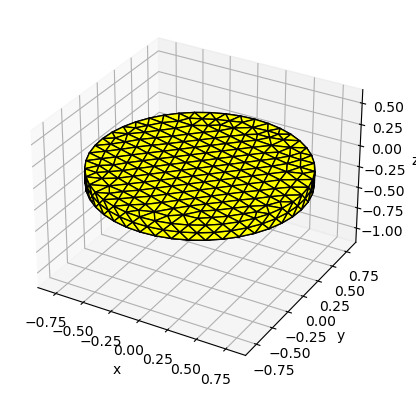

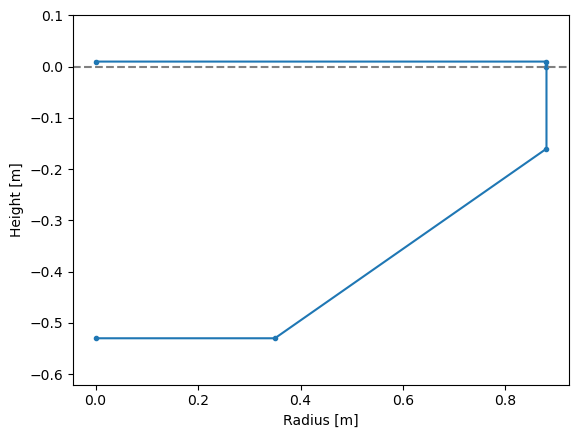

In [3]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True)  # specific to WaveBot

#### Frequency and mesh check
We will analyze 50 frequencies with a spacing of 0.05 Hz. These frequencies will be used for the Fourier representation of both the wave and the desired PTO force in the pseudo-spectral problem. See the Theory section of the Documentation for more details on the pseudo-spectral problem formulation.

The `fb.minimal_computable_wavelength` parameter checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine. This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [4]:
f1 = 0.05
nfreq = 50
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

min_computable_wavelength = fb.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

#### BEM
With our Capytaine floating body created, we can now run the Boundary Element Method solver in Capytaine to get the hydrostatic and hydrodynamic coefficients of our WEC object. This is wrapped into the `wecopttool.run_bem` function.

If you would like to save our BEM data to a NetCDF file for future use, see the `wecopttool.write_netcdf` function.

In [5]:
bem_data = wot.run_bem(fb, freq)

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.


('Heave', 'Heave')


#### PTO
WecOptTool includes the `PTO` class to encompass all properties of the power take-off system of the WEC. Data wrapped into our `PTO` class will be used to help define our `WEC` object and optimization problem later.

To create an instance of the `PTO` class, we need:
- The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom. The PTO extracts power directly from the WEC's heave in this case, so the kinematics matrix is simply the $1 \times 1$ identity matrix.
- The definition of the PTO controller. The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force. However, we will be using an unstructured controller in this case, so we will set `None` for the controller.
- Any PTO impedance. We're only interested in mechanical power for this first problem, so we will leave this empty for now
- The non-linear power conversion loss (assumed 0% if `None`)
- The PTO system name, if desired

In [6]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = wot.pto.controller_pi
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

Now let's define the PTO forcing on the WEC and the PTO constraints. For our optimization problem, the constraints must be in the correct format for `scipy.optimize.minimize()`. We will enforce the constraint at 4 times more points than the dynamics (see Theory for why this is helpful for the pseudo-spectral problem).

In [7]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 600
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = []

#### `WEC` creation
We are now ready to create the `WEC` object itself! Since we ran our BEM already, we can define the object using the `wecopttool.WEC.from_bem` function. If we saved our BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [8]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

Note: We might receive a warning regarding negative linear damping values. Per default, WecOptTool ensures that the BEM data does not contain non-negative damping values. If you would like to correct the BEM solution manually to a minimum damping value you can specify `min_damping`. 

### Waves
The wave environment must be specified as a 2-dimensional `xarray.DataArray` containing the complex amplitude (m). 
The two coordinates are the radial frequency ``omega`` (rad/s)  and the direction ``wave_direction`` (rad). 
The `wecopttool.waves` submodule contains functions for creating this `xarray.DataArray` for different types of wave environments. 

In this case we will use a regular wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m. 
We will use the `wecopttool.waves.regular_wave` function. 

In [74]:
print(wec.residual())

TypeError: WEC.residual() missing 3 required positional arguments: 'x_wec', 'x_opt', and 'waves'

In [31]:
amplitude = 0.0625  
wavefreq = 0.3
phase = 30
wavedir = 0
waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

fb_res = wec_from_floatingbody.residual(x_wec_0, x_opt_0, waves)



# irregular
Hs = 1
Tp = 5
nrealizations = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)

print(waves)


import wavespectra as ws
import os 

f1 = 0.02
nfreq = 24
time = '2020-01-01T01:40:00.000000000'
freq = wot.frequency(f1, nfreq, False)
ndbc_dir = r'C:\Users\jtgrasb\Documents\GitHub\WecOptTool\tests\data\ndbc'

markers = ('w', 'd', 'i', 'j', 'k')
files = [f'41013{i}2020.txt' for i in markers]
spec = ws.read_ndbc_ascii([os.path.join(ndbc_dir, file) for file in files])
ndbc = spec.sel(time=time).interp(freq=freq)

efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
print(efth)
#efth = ndbc.efth


    
#waves_irregular = wot.waves.irregular_wave(ndbc.efth)


<xarray.DataArray 'wave_elev' (omega: 24, wave_direction: 1, realization: 1)>
array([[[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

...

       [[0.05412659+0.03125j]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]],

       [[0.        +0.j     ]]])
Coordinates:
  * omega           (omega) float64 0.1257 0.2513 0.377 ... 2.765 2.89 3.016
    freq            (omega) float64 0.02 0.04 0.06 0.08 ... 0.42 0.44 0.46 0.48
  * wave_direction  (wave_direction) float64 0.0
  * realization     (realization) int3

C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\wavespectra\input\ndbc_ascii.py:62: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\wavespectra\input\ndbc_ascii.py:62: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\wavespectra\input\ndbc_ascii.py:62: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
C:\Users\jtgrasb\Anaconda3\envs\wecop

<xarray.DataArray (freq: 24, dir: 1)>
array([[0.00000000e+00],
       [0.00000000e+00],
       [7.60203492e-65],
       [1.01599627e-19],
       [1.05843212e-07],
       [1.31685087e-03],
       [5.12725934e-02],
       [2.26078316e-01],
       [3.94223203e-01],
       [4.47820432e-01],
       [4.13029246e-01],
       [3.43456241e-01],
       [2.71448097e-01],
       [2.09630818e-01],
       [1.60572433e-01],
       [1.22996068e-01],
       [9.46365279e-02],
       [7.33173036e-02],
       [5.72590589e-02],
       [4.51001883e-02],
       [3.58293549e-02],
       [2.87048281e-02],
       [2.31845596e-02],
       [1.88718395e-02]])
Coordinates:
  * freq     (freq) float64 0.02 0.04 0.06 0.08 0.1 ... 0.4 0.42 0.44 0.46 0.48
  * dir      (dir) float64 0.0
Attributes:
    long_name:                 omnidirectional spectrum
    units:                     m^2/Hz
    Omnidirectional Spectrum:  Pierson-Moskowitz
<xarray.DataArray 'realization' (realization: 2)>
array([0, 1])
Coordinates:
  * r

In [73]:
import xarray as xr

f1 = .12
nfreq = 5

n = np.random.randint(1, nfreq)
directions = [0.0, 30.0]
nrealizations = 1
ndir = len(directions)

amplitudes = np.zeros([nfreq, ndir, nrealizations])
phases = np.zeros([nfreq, ndir, nrealizations])
amp0, amp1 = 1.2, 2.1
phase0, phase1 = 26, -13
amplitudes[n-1, :, :] = [[amp0], [amp1]]
phases[n-1, :, :] = [[phase0], [phase1]]
print(phases)

#waves = wot.waves.elevation_fd(f1, nfreq, directions, nrealizations, amplitudes, phases)

directions = np.atleast_1d(wot.waves.degrees_to_radians(directions, sort=False))
ndirections = len(directions)
realization = range(nrealizations)
freq = wot.waves.frequency(f1, nfreq, False)
omega = freq*2*np.pi

dims = ('omega', 'wave_direction','realization')
omega_attr = {'long_name': 'Radial frequency', 'units': 'rad/s'}
freq_attr = {'long_name': 'Frequency', 'units': 'Hz'}
dir_attr = {'long_name': 'Wave direction', 'units': 'rad'}
real_attr = {'long_name': 'Phase realization', 'units': ''}
coords = {'omega': (dims[0], omega, omega_attr),
          'freq': (dims[0], freq, freq_attr),
          'wave_direction': (dims[1], directions, dir_attr),
          'realization': (dims[2], realization, real_attr)}

if amplitudes is None:
    amplitudes = np.zeros([nfreq, ndirections, nrealizations])

if phases is None:
    phases = wot.waves.random_phase([nfreq, ndirections, nrealizations],seed)
else:
    phases = wot.waves.degrees_to_radians(phases, False)

camplitude = amplitudes * np.exp(1j*phases)

attr = {} if attr is None else attr
attrs = {'units': 'm', 'long_name': 'Wave elevation'} | attr

print(realization)
print(np.shape(camplitude))
print(dims)
print(coords)
print(np.shape(phases))
phases = wot.waves.random_phase([nfreq, ndirections, nrealizations],seed)
print(np.shape(phases))


waves = xr.DataArray(camplitude, dims=dims, coords=coords,
                     attrs=attrs, name='wave_elev')

[[[  0.]
  [  0.]]

 [[ 26.]
  [-13.]]

 [[  0.]
  [  0.]]

 [[  0.]
  [  0.]]

 [[  0.]
  [  0.]]]
range(0, 1)
(5, 2, 1)
('omega', 'wave_direction', 'realization')
{'omega': ('omega', array([0.75398224, 1.50796447, 2.26194671, 3.01592895, 3.76991118]), {'long_name': 'Radial frequency', 'units': 'rad/s'}), 'freq': ('omega', array([0.12, 0.24, 0.36, 0.48, 0.6 ]), {'long_name': 'Frequency', 'units': 'Hz'}), 'wave_direction': ('wave_direction', array([0.        , 0.52359878]), {'long_name': 'Wave direction', 'units': 'rad'}), 'realization': ('realization', range(0, 1), {'long_name': 'Phase realization', 'units': ''})}
(5, 2, 1)
(5, 2, 1)


In [28]:
import xarray as xr

nrealizations = 2
seed = None
phases = None

f1, nfreq = wot.waves.frequency_parameters(efth.freq.values, False)
directions = efth.dir.values
df = f1
dd = np.sort(directions)[1]-np.sort(directions)[0]

values = efth.values
values[values<0] = np.nan
amplitudes = np.sqrt(2 * values * df * dd)
amplitudes = np.expand_dims(amplitudes,axis=2)
attr = {'Wave type': 'Irregular'}

directions = np.atleast_1d(wot.waves.degrees_to_radians(directions, sort=False))
ndirections = len(directions)
realization = range(nrealizations)
freq = wot.waves.frequency(f1, nfreq, False)
omega = freq*2*np.pi

dims = ('omega', 'wave_direction','realization')
omega_attr = {'long_name': 'Radial frequency', 'units': 'rad/s'}
freq_attr = {'long_name': 'Frequency', 'units': 'Hz'}
dir_attr = {'long_name': 'Wave direction', 'units': 'rad'}
real_attr = {'long_name': 'Phase realization', 'units': ''}
coords = {'omega': (dims[0], omega, omega_attr),
          'freq': (dims[0], freq, freq_attr),
          'wave_direction': (dims[1], directions, dir_attr),
          'realization': (dims[2], realization, real_attr)}

if amplitudes is None:
    amplitudes = np.zeros([nfreq, ndirections, nrealizations])

if phases is None:
    phases = wot.waves.random_phase([nfreq, ndirections, nrealizations],seed)
else:
    phases = degrees_to_radians(phases, False)

camplitude = amplitudes * np.exp(1j*phases)

attr = {} if attr is None else attr
attrs = {'units': 'm', 'long_name': 'Wave elevation'} | attr

print(realization)
print(np.shape(camplitude))
print(dims)
print(coords)

waves = xr.DataArray(camplitude, dims=dims, coords=coords,
                     attrs=attrs, name='wave_elev')

range(0, 2)
(24, 36, 2)
('omega', 'wave_direction', 'realization')
{'omega': ('omega', array([0.12566371, 0.25132741, 0.37699112, 0.50265482, 0.62831853,
       0.75398224, 0.87964594, 1.00530965, 1.13097336, 1.25663706,
       1.38230077, 1.50796447, 1.63362818, 1.75929189, 1.88495559,
       2.0106193 , 2.136283  , 2.26194671, 2.38761042, 2.51327412,
       2.63893783, 2.76460154, 2.89026524, 3.01592895]), {'long_name': 'Radial frequency', 'units': 'rad/s'}), 'freq': ('omega', array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48]), {'long_name': 'Frequency', 'units': 'Hz'}), 'wave_direction': ('wave_direction', array([ 0.        ,  0.17453293,  0.34906585,  0.52359878,  0.6981317 ,
        0.87266463,  1.04719755,  1.22173048,  1.3962634 ,  1.57079633,
        1.74532925,  1.91986218,  2.0943951 ,  2.26892803,  2.44346095,
        2.61799388,  2.7925268 ,  2.96705973,  3.141

In [ ]:
# check long-crested wave with multiple directions and realizations

### Objective function
The objective function is the quantity (scalar) we want to optimize—in this case, the average mechanical power. The objective function is itself a function of the optimization state, the size of which we need to properly define our call to `scipy.optimize.minimize()`. The average mechanical power can be taken directly from the `PTO` object we created.

One technical quirk here: `nstate_opt` is one smaller than would be expected for a state space representing the mean (DC) component and the real and imaginary Fourier coefficients. This is because WecOptTool excludes the imaginary Fourier component of the highest frequency (the 2-point wave). Since the 2-point wave is sampled at multiples of $\pi$, the imaginary component is evaluated as $sin(n\pi); n = 0, 1, 2, ..., n_{freq}$, which is always zero. Excluding this component speeds up the optimization as the state space is reduced by one.

In [56]:
obj_fun = pto.average_power
nstate_opt = 2

### Solve
We are now ready to solve the problem. WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

Note that the only required inputs for defining and solving the problem are: (1) the waves, (2) the objective function, and (3) the size of the optimization state. Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance. See `scipy.optimize.minimize` docs for more details.

To help the optimization we will scale the problem before solving it (see Documentation). WecOptTool allows you to scale the WEC dynamics state, your optimization state (in this case the Fourier coefficients for the PTO force), and the objective function separately. See the `wecopttool.WEC.solve()` function for more information.


Pay attention to the `Exit mode`: an exit mode of $0$ indicates a successful solution. For an easy problem (linear, single Dof, unconstrained, etc.) your iterations shouldn't need to exceed 100. If they do, try adjusting the scales by orders of magnitude, one at a time.

In [65]:
import logging
logging.basicConfig(level=logging.INFO)

options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-4
scale_obj = 1e-3

results = wec.solve(
    waves_irregular, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_mechanical_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.25e+01, 1.59e+00, -1.07e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.25e+01, 1.59e+00, -1.07e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.26e+00, -6.26e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.26e+00, -6.26e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.21e+01, 1.01e+00, -2.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.21e+01, 1.01e+00, -2.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 1.09e+00, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 1.09e+00, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), m

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.18e+00, -6.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.18e+00, -6.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.18e+00, -6.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.18e+00, -6.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.89e+01, 2.17e+00, -6.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.89e+01, 2.17e+00, -6.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.76e+01, 2.13e+00, -6.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.76e+01, 2.13e+00, -6.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.91e+01, 2.12e+00, -6.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.91e+01, 2.12e+00, -6.57e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272463
            Iterations: 60
            Function evaluations: 84
            Gradient evaluations: 60
Optimal average mechanical power: -6809.001247272463 W


### Analyzing results
We will use two post-processing functions to obtain frequency- and time-domain results for the WEC and PTO responses. The pseudospectral method gives continuous in time results. To get smoother looking plots, we specify the number of subpoints betweeen co-location points. In this case we will use 5. 

In [66]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results[0], waves.sel(realization=0), nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(results[0], waves.sel(realization=0), nsubsteps=nsubsteps)

The `pto.post_process` function returns `xarray.Dataset`s, which have built-in integration with PyPlot for smart plotting that automagically sets titles and formatting. We will plot the mechanical power (`mech_power`), position (`pos`), and the PTO force (`force`).

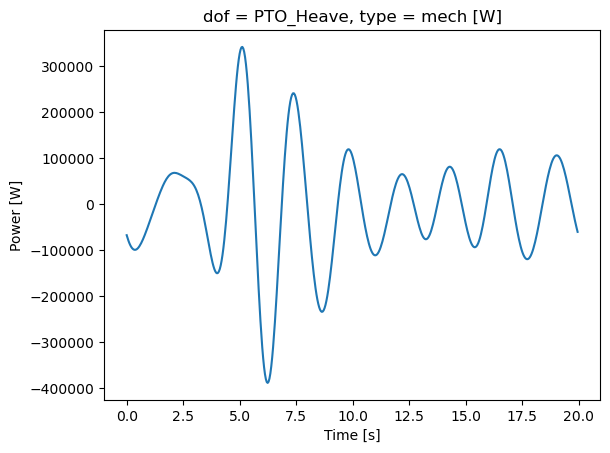

In [67]:
plt.figure()
pto_tdom['power'].loc['mech',:,:].plot()

We could similarly plot any time- or frequency-domain repsonse of the WEC or PTO. For instance, here is the PTO heave motion.

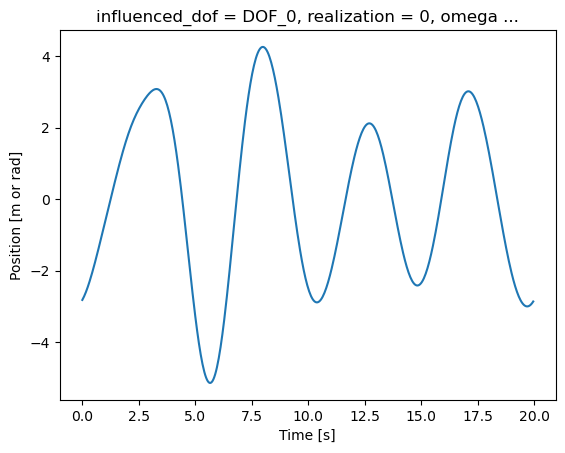

In [68]:
plt.figure()
wec_tdom['pos'].plot()

(500, 1)


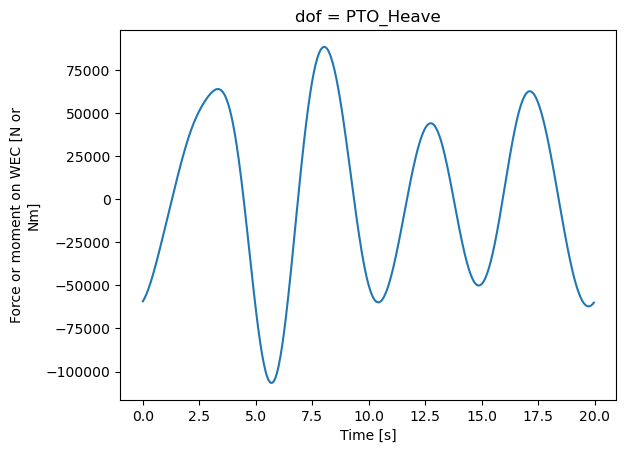

In [69]:
plt.figure()
pto_tdom['force'].plot()
print(np.shape(pto_tdom['force']))

Note that there are other dynamic responses available in the post-processed WEC and PTO variables (`wec_tdom`, `pto_tdom`, `wec_fdom`, `pto_fdom`). For example, the time domain PTO variable contains the following response:

In [16]:
pto_tdom

<xarray.Dataset>
Dimensions:  (time: 500, dof: 1, type: 2)
Coordinates:
  * time     (time) float64 0.0 0.04 0.08 0.12 0.16 ... 19.84 19.88 19.92 19.96
  * dof      (dof) <U9 'PTO_Heave'
  * type     (type) <U4 'mech' 'elec'
Data variables:
    pos      (time, dof) float64 0.06909 0.06061 0.05159 ... 0.08391 0.0769
    vel      (time, dof) float64 -0.2042 -0.2193 -0.2308 ... -0.1646 -0.1858
    acc      (time, dof) float64 -0.42 -0.3345 -0.2416 ... -0.5617 -0.4963
    force    (time, dof) float64 99.85 107.7 113.7 117.9 ... 67.61 79.59 90.42
    power    (type, time, dof) float64 -20.39 -23.61 -26.26 ... -13.1 -16.8
Attributes:
    time_created_utc:  2023-12-04 18:46:31.602763

## 2. Optimal control for maximum electrical power

The rest of this tutorial will focus on optimizing for electrical power (new objective function) rather than mechanical, as this is a form of power that is usable and transportable.

Since we're still dealing with the same WaveBot as in part 1, we can reuse the BEM and wave data from before. Look back at part 1 if you need a refresher on how to create these data.

<div>
<img src="https://live.staticflickr.com/65535/52435033525_b8efc28d16_k.jpg" width="1000">
</div>
The WEC-PTO kinematics remain the same as well (unity). The major difference now is that we consider the dynamics of PTO, since they impact the electrical power and we shall not assume a lossless PTO.

We will express the PTO's dynamics in form of a 2-port impedance model, to incoporate the dynamics of the drive-train and the dynamics of the generator.
The additional mechanical energy storage through the drive-train is modelled using Newton's second law and we assume a linear generator using a power-invariant park transform.

The PTO impedance matrix components are then obtained under open-circuit  conditions, i.e.  no  load  current  or  no  WEC  velocity,  respectively.

The attentive user might have noticed that the amplitude of the position, force and power signals is about half the magnitude of the signals we plotted in the first part of the tutorial. We can see that optimizing for electrical power requires optimal state trajectories with smaller amplitudes. For most WECs the electrical power is the usable form of power, thus the WEC should be designed for electrical power and we can avoid over-designing, which would results from expecting the forces associated with the optimal trajectories for mechanical power maximisation.

## 3. Control co-design of the WEC geometry for maximum electrical power
The first two examples only used the inner optimization loop in WecOptTool to optimize PTO power. Here in Part 3 we bring it all together and show how to use both the inner and outer optimization loops in WecOptTool to do control co-optimization of a hull design in conjunction with an optimal controller for electrical power.
Again, we use the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average produced electrical power, while maintaining a constant hull volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius (`r2`).

This example demonstrates a complete case of the types of optimization studies WecOptTool is meant for. 
The main optimization (outer optimization loop) is to find the optimal geometry (radius `r2`), and for each geometry considered the optimal PTO force (inner optimization loop) will be found.
The inner loop was showcased in Example 2 and uses a gradient-based optimization method, with the gradients obtained with automatic differentiation. 
The outer loop optimization is for the user to setup. 
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute`.  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg) 
<div>
<img src="https://live.staticflickr.com/65535/52434071157_187eb4334c_k.jpg" width="1000">
</div>



### Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Part 2 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

Note that in this case the magnitude of average power between the different keel radii is rather small, this is because the PTO force constraint is active most of the time, therefore all considered geometries perform similarily. If you remove the PTO constraint and re-run the co-optimization study you will see that the impact of radius on average electrical power is significantly higher.

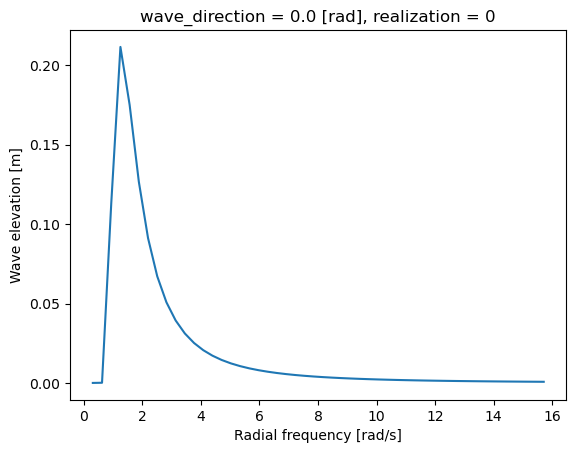

In [70]:
# irregular
Hs = 1
Tp = 5

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")

meanpower = []

waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 100)

fig, ax = plt.subplots()
plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
    ax=ax, color='C0')

In [71]:
# calculate max power
Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
ampSpect = waves_irregular.sel(realization=0).values
Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

hydro_data = wot.add_linear_friction(bem_data)
Zi = wot.hydrodynamic_impedance(hydro_data)

# Maximum Mechanical Power
P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
P_ub = - sum(np.squeeze(P_ub_vec)).values

print(f'Max Theoretical Power: {P_ub}')

Max Theoretical Power: -11835.94928017825


In [73]:
results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt=2,
    scale_x_wec=1e1,
    scale_x_opt=1e-4,
    scale_obj=1e-3,
)
power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')


INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.47e+00, -6.63e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.47e+00, -6.63e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.52e+00, -2.52e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.52e+00, -2.52e+01]
INFO:wecopttool.core:Scaled [max(x_wec), m

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727305
            Iterations: 46
            Function evaluations: 63
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.42e+00, -6.35e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.42e+00, -6.35e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 1.48e+00, -2.31e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 1.48e+00, -2.31e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 1.48e+00, -2.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 1.48e+00, -2.30e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 2.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 2.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727161
            Iterations: 45
            Function evaluations: 53
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.60e+00, -7.27e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.60e+00, -7.27e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 1.62e+00, -2.88e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 1.62e+00, -2.88e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.66e+00, -3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.66e+00, -3.10e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.67e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.67e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 3.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 3.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271495
            Iterations: 43
            Function evaluations: 51
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.61e+01, 1.62e+00, -7.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.61e+01, 1.62e+00, -7.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.56e+00, -3.02e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.56e+00, -3.02e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 1.56e+00, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 1.56e+00, -2.77e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 4.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 4.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247270955
            Iterations: 44
            Function evaluations: 53
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.62e+01, 1.65e+00, -7.51e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.62e+01, 1.65e+00, -7.51e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.86e+00, 1.65e+00, -3.04e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.86e+00, 1.65e+00, -3.04e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.69e+00, -3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.69e+00, -3.28e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272144
            Iterations: 46
            Function evaluations: 62
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.54e+00, -7.03e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.54e+00, -7.03e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.50e+00, -2.76e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.50e+00, -2.76e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+00, 1.47e+00, -2.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+00, 1.47e+00, -2.40e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271799
            Iterations: 46
            Function evaluations: 60
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.50e+01, 1.48e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.50e+01, 1.48e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.53e+00, -2.58e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.53e+00, -2.58e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.56e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.56e+00, -2.75e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472716746
            Iterations: 51
            Function evaluations: 72
            Gradient evaluations: 51


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.42e+01, 1.35e+00, -6.08e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.42e+01, 1.35e+00, -6.08e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.43e+00, -2.15e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.43e+00, -2.15e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 1.43e+00, -2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 1.43e+00, -2.26e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472637484
            Iterations: 49
            Function evaluations: 66
            Gradient evaluations: 49


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.54e+00, -7.06e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.54e+00, -7.06e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 1.51e+00, -2.87e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 1.51e+00, -2.87e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 1.50e+00, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 1.50e+00, -2.58e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 9.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 9.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272837
            Iterations: 44
            Function evaluations: 57
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.53e+00, -6.96e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.53e+00, -6.96e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.52e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.52e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 1.51e+00, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 1.51e+00, -2.65e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272657
            Iterations: 47
            Function evaluations: 60
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.47e+00, -6.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.47e+00, -6.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 1.56e+00, -2.42e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 1.56e+00, -2.42e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 1.63e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 1.63e+00, -2.75e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 11.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 11.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271675
            Iterations: 43
            Function evaluations: 51
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.50e+00, -6.79e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.50e+00, -6.79e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+00, 1.51e+00, -2.63e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+00, 1.51e+00, -2.63e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.52e+00, -2.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.52e+00, -2.53e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271861
            Iterations: 46
            Function evaluations: 54
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.66e+01, 1.69e+00, -7.74e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.66e+01, 1.69e+00, -7.74e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+00, 1.65e+00, -3.18e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+00, 1.65e+00, -3.18e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 1.69e+00, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 1.69e+00, -3.31e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 13.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 13.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271708
            Iterations: 44
            Function evaluations: 55
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.11e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.11e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.36e+01, 1.30e+00, -5.80e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.36e+01, 1.30e+00, -5.80e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 1.45e+00, -1.98e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 1.45e+00, -1.98e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+00, 1.47e+00, -2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+00, 1.47e+00, -2.28e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727133
            Iterations: 46
            Function evaluations: 62
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.51e+00, -6.86e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.51e+00, -6.86e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 1.51e+00, -2.59e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 1.51e+00, -2.59e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 1.50e+00, -2.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 1.50e+00, -2.47e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472714765
            Iterations: 46
            Function evaluations: 55
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.66e+01, 1.67e+00, -7.73e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.66e+01, 1.67e+00, -7.73e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.22e+00, 1.60e+00, -3.29e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.22e+00, 1.60e+00, -3.29e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 1.61e+00, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 1.61e+00, -3.09e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 16.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 16.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247269158
            Iterations: 43
            Function evaluations: 52
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.53e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.53e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 1.50e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 1.50e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 1.48e+00, -2.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 1.48e+00, -2.34e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124726669
            Iterations: 48
            Function evaluations: 62
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.46e+00, -6.56e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.46e+00, -6.56e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.08e+00, 1.46e+00, -2.34e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.08e+00, 1.46e+00, -2.34e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.44e+00, -2.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.44e+00, -2.22e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271673
            Iterations: 48
            Function evaluations: 61
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.58e+00, -7.21e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.58e+00, -7.21e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.71e+00, 1.53e+00, -2.96e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.71e+00, 1.53e+00, -2.96e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 1.51e+00, -2.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 1.51e+00, -2.67e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.24e+01, 2.07e+00, -6.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.24e+01, 2.07e+00, -6.79e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247274241
            Iterations: 53
            Function evaluations: 69
            Gradient evaluations: 53


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.45e+00, -6.49e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.45e+00, -6.49e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 1.51e+00, -2.35e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 1.51e+00, -2.35e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.60e+00, 1.52e+00, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.60e+00, 1.52e+00, -2.49e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 20.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 20.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271992
            Iterations: 45
            Function evaluations: 58
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.45e+01, 1.42e+00, -6.41e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.45e+01, 1.42e+00, -6.41e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 1.51e+00, -2.40e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 1.51e+00, -2.40e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 1.55e+00, -2.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 1.55e+00, -2.63e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247270385
            Iterations: 46
            Function evaluations: 60
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.49e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.49e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 1.50e+00, -2.49e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 1.50e+00, -2.49e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+00, 1.50e+00, -2.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+00, 1.50e+00, -2.39e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 22.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 22.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247275878
            Iterations: 44
            Function evaluations: 51
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.56e+00, -7.07e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.56e+00, -7.07e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 1.57e+00, -2.76e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 1.57e+00, -2.76e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 1.59e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 1.59e+00, -2.75e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247273429
            Iterations: 47
            Function evaluations: 62
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.53e+00, -6.91e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.53e+00, -6.91e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.77e+00, 1.60e+00, -2.71e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.77e+00, 1.60e+00, -2.71e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.58e+00, 1.66e+00, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.58e+00, 1.66e+00, -3.00e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 24.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 24.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271708
            Iterations: 45
            Function evaluations: 57
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.59e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.59e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.59e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.59e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+00, 1.64e+00, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+00, 1.64e+00, -2.93e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 25.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 25.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247270937
            Iterations: 44
            Function evaluations: 56
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.60e+01, 1.62e+00, -7.39e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.60e+01, 1.62e+00, -7.39e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 1.58e+00, -3.01e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 1.58e+00, -3.01e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+00, 1.58e+00, -2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+00, 1.58e+00, -2.83e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727113
            Iterations: 47
            Function evaluations: 60
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.50e+01, 1.47e+00, -6.67e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.50e+01, 1.47e+00, -6.67e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 1.50e+00, -2.59e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 1.50e+00, -2.59e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+00, 1.51e+00, -2.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+00, 1.51e+00, -2.59e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.58e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272239
            Iterations: 46
            Function evaluations: 57
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.44e+00, -6.49e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.44e+00, -6.49e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.40e+00, 1.52e+00, -2.50e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.40e+00, 1.52e+00, -2.50e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.69e+00, 1.53e+00, -2.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.69e+00, 1.53e+00, -2.63e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247270996
            Iterations: 48
            Function evaluations: 60
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.46e+00, -6.61e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.46e+00, -6.61e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 1.54e+00, -2.51e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 1.54e+00, -2.51e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.61e+00, -2.82e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.61e+00, -2.82e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271628
            Iterations: 49
            Function evaluations: 63
            Gradient evaluations: 49


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.46e+00, -6.54e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.46e+00, -6.54e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.52e+00, -2.39e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.52e+00, -2.39e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.97e+00, 1.58e+00, -2.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.97e+00, 1.58e+00, -2.70e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 30.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 30.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271013
            Iterations: 45
            Function evaluations: 54
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.53e+00, -6.95e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.53e+00, -6.95e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 1.51e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 1.51e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 1.51e+00, -2.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 1.51e+00, -2.62e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+01, 2.07e+00, -6.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+01, 2.07e+00, -6.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271185
            Iterations: 52
            Function evaluations: 68
            Gradient evaluations: 52


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.60e+01, 1.63e+00, -7.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.60e+01, 1.63e+00, -7.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+00, 1.61e+00, -3.10e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+00, 1.61e+00, -3.10e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.62e+00, 1.63e+00, -3.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.62e+00, 1.63e+00, -3.12e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271359
            Iterations: 47
            Function evaluations: 57
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.47e+00, -6.66e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.47e+00, -6.66e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.55e+00, -2.59e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.55e+00, -2.59e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.61e+00, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.61e+00, -2.87e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247270688
            Iterations: 50
            Function evaluations: 67
            Gradient evaluations: 50


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.48e+00, -6.59e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.48e+00, -6.59e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 1.53e+00, -2.30e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 1.53e+00, -2.30e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 1.58e+00, -2.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 1.58e+00, -2.60e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472681245
            Iterations: 48
            Function evaluations: 63
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.42e+00, -6.39e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.42e+00, -6.39e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 1.45e+00, -2.34e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 1.45e+00, -2.34e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.70e+00, 1.44e+00, -2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.70e+00, 1.44e+00, -2.28e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472702925
            Iterations: 47
            Function evaluations: 57
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.43e+00, -6.41e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.43e+00, -6.41e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 1.50e+00, -2.30e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 1.50e+00, -2.30e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.52e+00, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.52e+00, -2.50e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271697
            Iterations: 47
            Function evaluations: 58
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.44e+00, -6.48e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.44e+00, -6.48e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 1.51e+00, -2.39e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 1.51e+00, -2.39e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.55e+00, -2.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.55e+00, -2.60e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271878
            Iterations: 48
            Function evaluations: 64
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.45e+00, -6.55e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.45e+00, -6.55e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 1.46e+00, -2.44e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 1.46e+00, -2.44e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 1.44e+00, -2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 1.44e+00, -2.28e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247268771
            Iterations: 46
            Function evaluations: 60
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.55e+00, -7.04e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.55e+00, -7.04e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 1.53e+00, -2.81e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 1.53e+00, -2.81e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.54e+00, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.54e+00, -2.69e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 39.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 39.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727245
            Iterations: 43
            Function evaluations: 45
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.44e+01, 1.41e+00, -6.34e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.44e+01, 1.41e+00, -6.34e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 1.45e+00, -2.34e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 1.45e+00, -2.34e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 1.45e+00, -2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 1.45e+00, -2.28e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472531765
            Iterations: 47
            Function evaluations: 59
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.51e+00, -6.85e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.51e+00, -6.85e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.52e+00, -2.71e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.52e+00, -2.71e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.51e+00, -2.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.51e+00, -2.62e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 41.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 41.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271216
            Iterations: 44
            Function evaluations: 53
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.46e+00, -6.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.46e+00, -6.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.53e+00, -2.46e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.53e+00, -2.46e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 1.55e+00, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 1.55e+00, -2.66e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271565
            Iterations: 46
            Function evaluations: 59
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.57e+00, -7.14e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.57e+00, -7.14e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.56e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.56e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 1.58e+00, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 1.58e+00, -2.77e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271712
            Iterations: 47
            Function evaluations: 61
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.56e+00, -7.04e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.56e+00, -7.04e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.58e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.58e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 1.62e+00, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 1.62e+00, -2.77e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472725405
            Iterations: 47
            Function evaluations: 59
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.60e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.60e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.67e+00, -2.80e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.67e+00, -2.80e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.81e+00, 1.75e+00, -3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.81e+00, 1.75e+00, -3.28e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472712305
            Iterations: 46
            Function evaluations: 59
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.55e+00, -7.09e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.55e+00, -7.09e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+00, 1.56e+00, -2.82e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+00, 1.56e+00, -2.82e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.59e+00, -2.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.59e+00, -2.88e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.55e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.55e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 46.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 46.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271708
            Iterations: 43
            Function evaluations: 48
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.53e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.53e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 1.61e+00, -2.66e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 1.61e+00, -2.66e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.79e+00, 1.69e+00, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.79e+00, 1.69e+00, -3.00e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 47.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 47.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247277447
            Iterations: 45
            Function evaluations: 56
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.62e+01, 1.64e+00, -7.47e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.62e+01, 1.64e+00, -7.47e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.58e+00, -3.06e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.58e+00, -3.06e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.26e+00, 1.57e+00, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.26e+00, 1.57e+00, -2.76e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 48.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 48.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247268474
            Iterations: 44
            Function evaluations: 53
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.63e+01, 1.67e+00, -7.65e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.63e+01, 1.67e+00, -7.65e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.85e+00, 1.64e+00, -3.23e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.85e+00, 1.64e+00, -3.23e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+00, 1.66e+00, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+00, 1.66e+00, -3.26e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 49.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 49.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271701
            Iterations: 42
            Function evaluations: 46
            Gradient evaluations: 42


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.58e+01, 1.62e+00, -7.34e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.58e+01, 1.62e+00, -7.34e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 1.63e+00, -2.96e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 1.63e+00, -2.96e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 1.68e+00, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 1.68e+00, -3.26e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271505
            Iterations: 46
            Function evaluations: 57
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.45e+01, 1.41e+00, -6.29e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.45e+01, 1.41e+00, -6.29e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.95e+00, 1.47e+00, -2.21e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.95e+00, 1.47e+00, -2.21e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 1.48e+00, -2.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 1.48e+00, -2.33e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271399
            Iterations: 46
            Function evaluations: 57
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.52e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.52e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 1.51e+00, -2.66e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 1.51e+00, -2.66e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 1.49e+00, -2.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 1.49e+00, -2.52e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472548676
            Iterations: 47
            Function evaluations: 57
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.42e+01, 1.37e+00, -6.14e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.42e+01, 1.37e+00, -6.14e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 1.43e+00, -2.14e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 1.43e+00, -2.14e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+00, 1.43e+00, -2.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+00, 1.43e+00, -2.23e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247269634
            Iterations: 49
            Function evaluations: 57
            Gradient evaluations: 49


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.55e+00, -7.08e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.55e+00, -7.08e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.55e+00, -2.80e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.55e+00, -2.80e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.69e+00, 1.58e+00, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.69e+00, 1.58e+00, -2.86e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271695
            Iterations: 46
            Function evaluations: 57
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.50e+00, -6.80e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.50e+00, -6.80e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.53e+00, -2.69e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.53e+00, -2.69e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.54e+00, -2.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.54e+00, -2.68e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 55.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 55.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272272
            Iterations: 44
            Function evaluations: 51
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.51e+00, -6.85e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.51e+00, -6.85e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.88e+00, 1.57e+00, -2.69e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.88e+00, 1.57e+00, -2.69e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.97e+00, 1.64e+00, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.97e+00, 1.64e+00, -2.95e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271645
            Iterations: 46
            Function evaluations: 59
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.47e+00, -6.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.46e+01, 1.47e+00, -6.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 1.55e+00, -2.42e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 1.55e+00, -2.42e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+00, 1.62e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+00, 1.62e+00, -2.75e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 57.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 57.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247263959
            Iterations: 45
            Function evaluations: 56
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.63e+01, 1.65e+00, -7.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.63e+01, 1.65e+00, -7.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+00, 1.61e+00, -3.20e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+00, 1.61e+00, -3.20e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.32e+00, 1.64e+00, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.32e+00, 1.64e+00, -3.20e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 58.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 58.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472797
            Iterations: 42
            Function evaluations: 51
            Gradient evaluations: 42


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.60e+00, -7.25e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.60e+00, -7.25e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.59e+00, -2.81e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.59e+00, -2.81e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.15e+00, 1.62e+00, -2.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.15e+00, 1.62e+00, -2.92e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 59.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 59.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272529
            Iterations: 43
            Function evaluations: 49
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.52e+00, -6.89e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.52e+00, -6.89e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 1.57e+00, -2.65e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 1.57e+00, -2.65e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.82e+00, 1.63e+00, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.82e+00, 1.63e+00, -2.93e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.43e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.43e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.43e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.43e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 60.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 60.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472670685
            Iterations: 44
            Function evaluations: 54
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.65e+01, 1.65e+00, -7.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.65e+01, 1.65e+00, -7.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.04e+00, 1.57e+00, -3.12e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.04e+00, 1.57e+00, -3.12e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.56e+00, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.56e+00, -2.76e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 61.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 61.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472793635
            Iterations: 45
            Function evaluations: 55
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.53e+01, 1.54e+00, -6.97e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.53e+01, 1.54e+00, -6.97e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.59e+00, -2.77e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.59e+00, -2.77e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.33e+00, 1.64e+00, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.33e+00, 1.64e+00, -3.03e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271714
            Iterations: 46
            Function evaluations: 57
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.53e+01, 1.54e+00, -6.92e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.53e+01, 1.54e+00, -6.92e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.85e+00, 1.55e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.85e+00, 1.55e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.57e+00, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.57e+00, -2.66e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472716674
            Iterations: 46
            Function evaluations: 54
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.43e+01, 1.37e+00, -6.21e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.43e+01, 1.37e+00, -6.21e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.44e+00, -2.24e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.44e+00, -2.24e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 1.45e+00, -2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 1.45e+00, -2.31e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 64.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 64.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247269966
            Iterations: 44
            Function evaluations: 51
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.54e+00, -6.98e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.54e+00, -6.98e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.60e+00, 1.57e+00, -2.72e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.60e+00, 1.57e+00, -2.72e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+00, 1.61e+00, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+00, 1.61e+00, -2.95e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 65.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 65.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247270451
            Iterations: 42
            Function evaluations: 53
            Gradient evaluations: 42


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.58e+00, -7.16e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.58e+00, -7.16e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.67e+00, 1.59e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.67e+00, 1.59e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.60e+00, 1.64e+00, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.60e+00, 1.64e+00, -3.05e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247270357
            Iterations: 46
            Function evaluations: 61
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.44e+01, 1.39e+00, -6.23e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.44e+01, 1.39e+00, -6.23e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 1.42e+00, -2.23e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 1.42e+00, -2.23e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 1.39e+00, -2.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 1.39e+00, -2.08e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247253075
            Iterations: 46
            Function evaluations: 61
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.53e+01, 1.49e+00, -6.73e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.53e+01, 1.49e+00, -6.73e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 1.50e+00, -2.52e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 1.50e+00, -2.52e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.49e+00, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.49e+00, -2.50e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247267326
            Iterations: 47
            Function evaluations: 63
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.47e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+01, 1.47e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.51e+00, -2.60e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.51e+00, -2.60e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.53e+00, -2.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.53e+00, -2.68e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727622
            Iterations: 51
            Function evaluations: 72
            Gradient evaluations: 51


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.41e+00, -6.37e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.41e+00, -6.37e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.43e+00, -2.30e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.43e+00, -2.30e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 1.41e+00, -2.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 1.41e+00, -2.18e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247274826
            Iterations: 48
            Function evaluations: 58
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.58e+00, -7.11e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.58e+00, -7.11e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.58e+00, -2.66e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.58e+00, -2.66e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.62e+00, -2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.62e+00, -2.83e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247283899
            Iterations: 47
            Function evaluations: 60
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.58e+01, 1.61e+00, -7.30e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.58e+01, 1.61e+00, -7.30e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 1.62e+00, -2.95e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 1.62e+00, -2.95e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.66e+00, -3.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.66e+00, -3.12e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271941
            Iterations: 40
            Function evaluations: 45
            Gradient evaluations: 40


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.49e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.49e+00, -6.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.54e+00, -2.54e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.54e+00, -2.54e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 1.58e+00, -2.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 1.58e+00, -2.72e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 73.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 73.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247278265
            Iterations: 43
            Function evaluations: 54
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.51e+00, -6.79e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.51e+00, -6.79e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 1.50e+00, -2.57e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 1.50e+00, -2.57e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.34e+00, 1.49e+00, -2.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.34e+00, 1.49e+00, -2.39e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 74.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 74.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247265975
            Iterations: 45
            Function evaluations: 54
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.55e+00, -7.02e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.55e+01, 1.55e+00, -7.02e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.60e+00, -2.70e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.60e+00, -2.70e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.54e+00, 1.67e+00, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.54e+00, 1.67e+00, -3.00e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 75.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 75.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247264733
            Iterations: 45
            Function evaluations: 60
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.46e+00, -6.56e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.46e+00, -6.56e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 1.48e+00, -2.41e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 1.48e+00, -2.41e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.80e+00, 1.47e+00, -2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.80e+00, 1.47e+00, -2.31e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247291586
            Iterations: 49
            Function evaluations: 63
            Gradient evaluations: 49


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.12e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.38e+00, -1.12e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.42e+01, 1.40e+00, -6.22e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.42e+01, 1.40e+00, -6.22e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.97e+00, 1.51e+00, -2.22e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.97e+00, 1.51e+00, -2.22e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 1.54e+00, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 1.54e+00, -2.50e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727175
            Iterations: 47
            Function evaluations: 62
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.61e+00, -7.22e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.61e+00, -7.22e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.77e+00, 1.66e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.77e+00, 1.66e+00, -2.79e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.73e+00, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.73e+00, -3.22e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 78.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 78.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247276069
            Iterations: 45
            Function evaluations: 58
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.48e+00, -6.65e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.48e+00, -6.65e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 1.57e+00, -2.49e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 1.57e+00, -2.49e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 1.63e+00, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 1.63e+00, -2.76e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272489
            Iterations: 48
            Function evaluations: 65
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.50e+01, 1.53e+00, -6.86e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.50e+01, 1.53e+00, -6.86e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 1.61e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 1.61e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.69e+00, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.69e+00, -3.00e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271655
            Iterations: 46
            Function evaluations: 58
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.62e+00, -7.35e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.62e+00, -7.35e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.87e+00, 1.61e+00, -2.93e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.87e+00, 1.61e+00, -2.93e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 1.66e+00, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 1.66e+00, -3.14e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 81.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 81.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271317
            Iterations: 43
            Function evaluations: 49
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.64e+00, -7.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.59e+01, 1.64e+00, -7.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 1.64e+00, -3.00e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 1.64e+00, -3.00e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 1.69e+00, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 1.69e+00, -3.26e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247272056
            Iterations: 46
            Function evaluations: 59
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.44e+00, -6.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.47e+01, 1.44e+00, -6.44e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 1.48e+00, -2.33e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 1.48e+00, -2.33e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.47e+00, -2.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.47e+00, -2.38e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.71e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271705
            Iterations: 47
            Function evaluations: 58
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.62e+01, 1.66e+00, -7.61e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.62e+01, 1.66e+00, -7.61e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.67e+00, -3.17e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.67e+00, -3.17e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+00, 1.73e+00, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+00, 1.73e+00, -3.48e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 84.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 84.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271661
            Iterations: 45
            Function evaluations: 59
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.55e+00, -7.09e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.55e+00, -7.09e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.51e+00, -2.86e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.51e+00, -2.86e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.50e+00, -2.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.50e+00, -2.63e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247278827
            Iterations: 49
            Function evaluations: 64
            Gradient evaluations: 49


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.46e+00, -6.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.46e+00, -6.58e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 1.51e+00, -2.47e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 1.51e+00, -2.47e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.70e+00, 1.52e+00, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.70e+00, 1.52e+00, -2.54e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.8090012472744075
            Iterations: 46
            Function evaluations: 56
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.51e+00, -6.91e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.51e+00, -6.91e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.48e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.48e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.69e+00, 1.47e+00, -2.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.69e+00, 1.47e+00, -2.46e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for r

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271609
            Iterations: 46
            Function evaluations: 53
            Gradient evaluations: 46


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.60e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.60e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+00, 1.63e+00, -2.83e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+00, 1.63e+00, -2.83e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.69e+00, -3.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.69e+00, -3.17e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 88.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 88.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271903
            Iterations: 42
            Function evaluations: 51
            Gradient evaluations: 42


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.52e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.52e+00, -6.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+00, 1.58e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+00, 1.58e+00, -2.74e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.64e+00, -3.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.64e+00, -3.04e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 89.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 89.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247257156
            Iterations: 45
            Function evaluations: 56
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.40e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.49e+00, -6.81e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.52e+01, 1.49e+00, -6.81e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 1.50e+00, -2.69e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 1.50e+00, -2.69e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 1.50e+00, -2.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 1.50e+00, -2.62e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247267248
            Iterations: 49
            Function evaluations: 67
            Gradient evaluations: 49


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.44e+01, 1.40e+00, -6.25e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.44e+01, 1.40e+00, -6.25e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 1.48e+00, -2.18e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 1.48e+00, -2.18e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.49e+00, -2.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.49e+00, -2.35e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 91.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271725
            Iterations: 41
            Function evaluations: 49
            Gradient evaluations: 41


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.54e+00, -7.04e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.56e+01, 1.54e+00, -7.04e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.60e+00, 1.49e+00, -2.78e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.60e+00, 1.49e+00, -2.78e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 1.46e+00, -2.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 1.46e+00, -2.40e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 92.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 92.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271228
            Iterations: 45
            Function evaluations: 49
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.14e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.48e+00, -6.63e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.49e+01, 1.48e+00, -6.63e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 1.51e+00, -2.41e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 1.51e+00, -2.41e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 1.51e+00, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 1.51e+00, -2.50e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271616
            Iterations: 48
            Function evaluations: 63
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.46e+00, -6.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.48e+01, 1.46e+00, -6.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.74e+00, 1.52e+00, -2.48e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.74e+00, 1.52e+00, -2.48e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 1.56e+00, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 1.56e+00, -2.66e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271289
            Iterations: 48
            Function evaluations: 59
            Gradient evaluations: 48


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.40e+00, -1.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.67e+01, 1.70e+00, -7.80e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.67e+01, 1.70e+00, -7.80e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+00, 1.64e+00, -3.27e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+00, 1.64e+00, -3.27e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.81e+00, 1.64e+00, -3.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.81e+00, 1.64e+00, -3.17e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.17e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.17e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 95.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 95.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247267678
            Iterations: 43
            Function evaluations: 51
            Gradient evaluations: 43


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.58e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.57e+01, 1.58e+00, -7.19e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.59e+00, -2.85e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.59e+00, -2.85e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.41e+00, 1.64e+00, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.41e+00, 1.64e+00, -3.05e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.80900124727169
            Iterations: 53
            Function evaluations: 78
            Gradient evaluations: 53


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.41e+00, -1.34e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.13e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.45e+01, 1.42e+00, -6.31e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.45e+01, 1.42e+00, -6.31e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 1.50e+00, -2.14e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 1.50e+00, -2.14e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 1.52e+00, -2.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 1.52e+00, -2.39e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271698
            Iterations: 47
            Function evaluations: 55
            Gradient evaluations: 47


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.61e+01, 1.66e+00, -7.54e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.61e+01, 1.66e+00, -7.54e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.20e+00, 1.67e+00, -2.99e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.20e+00, 1.67e+00, -2.99e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+00, 1.72e+00, -3.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+00, 1.72e+00, -3.27e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 98.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 98.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271652
            Iterations: 44
            Function evaluations: 54
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.93e+01, 1.40e+00, -1.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.60e+01, 1.59e+00, -7.28e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.60e+01, 1.59e+00, -7.28e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 1.54e+00, -2.95e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 1.54e+00, -2.95e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 1.51e+00, -2.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 1.51e+00, -2.53e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 99.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 99.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247271712
            Iterations: 45
            Function evaluations: 52
            Gradient evaluations: 45


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+02, 1.42e+00, -1.35e+05]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.92e+01, 1.39e+00, -1.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.55e+00, -7.01e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.54e+01, 1.55e+00, -7.01e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.31e+00, 1.57e+00, -2.70e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.31e+00, 1.57e+00, -2.70e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+00, 1.60e+00, -2.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+00, 1.60e+00, -2.78e+00]
INFO:wecopttool.core

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+01, 2.07e+00, -6.81e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.809001247268813
            Iterations: 44
            Function evaluations: 52
            Gradient evaluations: 44
Optimal average power: -6809.00 W


In [74]:
import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],power_results),x=(['ind','ind2'],x_results)), 
                    coords=dict(ind=range(len(power_results)),ind2=range(len(x_results[0]))))
res_ds.to_netcdf('wavebot_power_convergence_05_linPI.nc')

In [21]:
# load results
import xarray as xr
res_ds = xr.load_dataset('wavebot_power_convergence_05_linPI.nc')

(-6809.1, -6808.9)

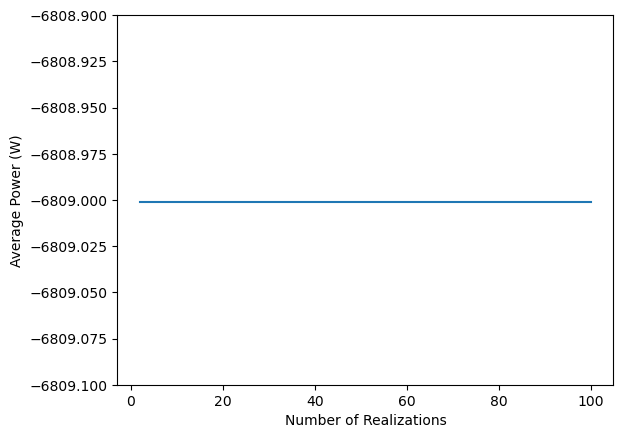

In [78]:
rolling_mean = []

for ind in range(len(res_ds['power'])):

    rolling_mean.append(np.mean(res_ds['power'][0:ind]))
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')
#plt.xlim([200, 400])
plt.ylim([-6809.1,-6808.9])

Text(0.5, 0, 'Number of Realizations')

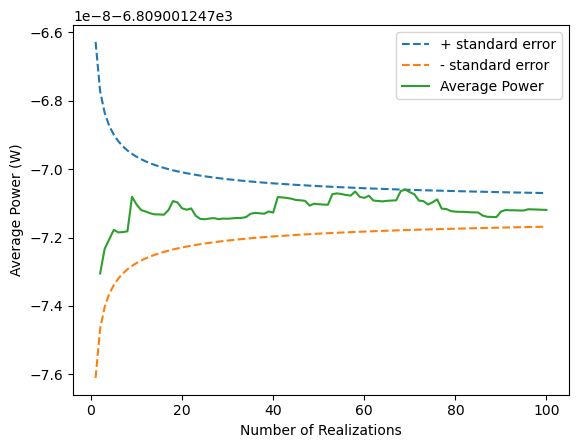

In [79]:
rolling_sem = []
rolling_var = []

stdev = np.std(res_ds['power'])

for ind in range(len(res_ds['power'])):
    
    #stdev = np.std(res_ds['power'][0:ind])
    
    rolling_var.append(stdev**2)
    
    rolling_sem.append(stdev/np.sqrt(ind+1))
    
rolling_sem_pos = [sum(x) for x in zip(rolling_sem, rolling_mean)]
rolling_sem_neg = [y-x for x, y in zip(rolling_sem, rolling_mean)]

rolling_sem_pos = [sum(x,rolling_mean[-1]) for x in zip(rolling_sem)]
rolling_sem_neg = [rolling_mean[-1]-x for x in rolling_sem]

rolling_var_pos = [sum(x) for x in zip(rolling_var, rolling_mean)]
rolling_var_neg = [y-x for x, y in zip(rolling_var, rolling_mean)]
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_sem_pos,'--',label='+ standard error')
plt.plot(range(1,len(res_ds['power'])+1),rolling_sem_neg,'--',label='- standard error')
#plt.plot(range(1,len(res_ds['power'])+1),rolling_var_pos)
#plt.plot(range(1,len(res_ds['power'])+1),rolling_var_neg)
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean,label='Average Power')
plt.legend()
plt.ylabel('Average Power (W)')
plt.xlabel('Number of Realizations')

Proportional and Integral Gain Standard Deviation:
7.86007432607205e-05
0.00013030288256778643
-747.1586702744988
20720.074589373617


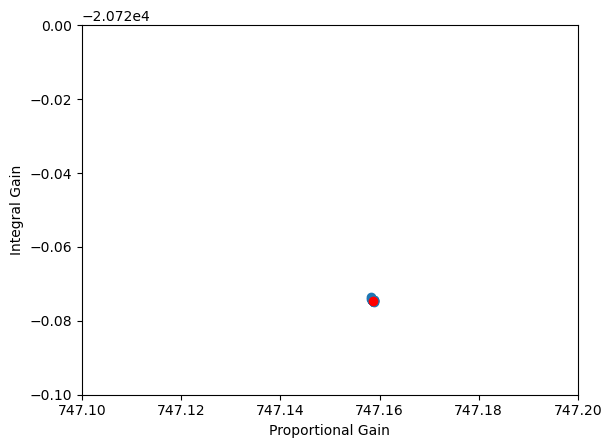

In [90]:
x_opts = []

for x in res_ds['x']:
    x_wec, x_opt = wec.decompose_state(x)
    x_opts.append(x_opt.to_numpy())

x_opts = np.array(x_opts)

x_diff = x_opts[-1] - x_opts[0]
#print(x_opts)

plt.figure() 
plt.scatter(-x_opts[:,0],-x_opts[:,1])
plt.xlim([747.1, 747.2])
plt.ylim([-20720.1, -20720])
plt.xlabel('Proportional Gain')
plt.ylabel('Integral Gain')

mean_p = np.mean(x_opts[:,0])
mean_i = np.mean(x_opts[:,1])
plt.scatter(-mean_p,-mean_i, c='r',marker='o')

print('Proportional and Integral Gain Standard Deviation:')
print(np.std(x_opts[:,0]))
print(np.std(x_opts[:,1]))

# calculate mean P and I gains
print(mean_p)
print(mean_i)

In [25]:
# Now, calculate the mean P and I gains and plug them back into each of the realizations to see the total average power

# calculate mean P and I gains
mean_p = np.mean(x_opts[:,0])
print(mean_p)
mean_i = np.mean(x_opts[:,1])
print(mean_i)

# set equality constraints on the P and I gains
constraints = []

bounds = ((mean_p,mean_p),(mean_i,mean_i))

# Create WEC
wec = wot.WEC.from_bem(bem_data,
        constraints=constraints,
        friction=None, 
        f_add=f_add,
        )

results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt=2,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
    bounds_opt=bounds,
)
power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')

-488.11613197543903
61.09653609056613
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8357178704528511
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimal average power: -83.57 W


C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Average Power (W)')

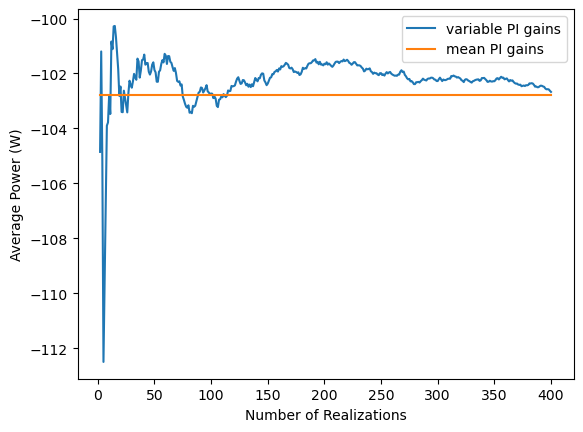

In [30]:
rolling_mean_const_PI = []

for ind in range(len(res_ds['power'])):

    rolling_mean_const_PI.append(np.mean(power_results[0:ind]))

plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean, label = 'variable PI gains')
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean_const_PI, label = 'mean PI gains')
plt.legend()
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [ ]:
wf1, wt1 = wec.post_process(results[0], waves_irregular.sel(realization=0), nsubsteps)
pf1, pt1 = pto.post_process(wec, results[0], waves_irregular.sel(realization=0), nsubsteps)

wf2, wt2 = wec.post_process(results[1], waves_irregular.sel(realization=1), nsubsteps)
pf2, pt2 = pto.post_process(wec, results[1], waves_irregular.sel(realization=1), nsubsteps)

plt.figure()
pt1['force'].plot()

plt.figure()
pt2['force'].plot()

consResults = []

for ind, result in enumerate(results):
    wf, wt = wec.post_process(result, waves_irregular.sel(realization=ind), nsubsteps)
    pf, pt = pto.post_process(wec, result, waves_irregular.sel(realization=ind), nsubsteps)
    consResults.append(np.any(abs(pt['force']) > f_max))
    print(ind)

print(sum(consResults))
print(400-sum(consResults))

In [ ]:
# load results
import xarray as xr
res_ds = xr.load_dataset('LUPA_power_convergence.nc')

In [ ]:
print(res_ds)

In [ ]:
rolling_mean = []

for ind in range(len(res_ds['power'])):

    rolling_mean.append(np.mean(res_ds['power'][0:ind]))
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [ ]:
# load results
import xarray as xr
res_ds = xr.load_dataset('pioneer_power_convergence.nc')

In [ ]:
rolling_mean = []

for ind in range(len(res_ds['power'])):

    rolling_mean.append(np.mean(res_ds['power'][0:ind]))
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [14]:
import time
import logging
logging.basicConfig(level=logging.INFO)

# compare run times vs. number of frequencies
nfreqs = np.linspace(50,300,11)
fend = 2.5

runtime = []
meanpower = []
Pmaxs = []

name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 200
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

# irregular
Hs = .4
Tp = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

# nrealizations based on how many it takes to reach 20 minutes

scale_x_wec=1e2
scale_x_opt=1e-2
scale_obj=1e-1
options = {'maxiter': 200}

minutes_needed = 20

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(fb, freq)

    sim_time = (1/(fend/nfreq))
    nrealizations_needed = minutes_needed*60/sim_time
    nrealizations_needed = np.round(nrealizations_needed)
    
    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
    )

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = int(nrealizations_needed))
    
    print(f'nfreq: {nfreq}')
    starttime = time.time()
    
    results = wec.solve(
        waves_irregular,
        obj_fun,
        nstate_opt=2*int(nfreq),
        optim_options=options, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
    )
    
    power_results = [result.fun for result in results]
    x_results = [result.x for result in results]
    print(f'Optimal average power: {np.mean(power_results):.2f} W')
    
    meanpower.append(np.mean(power_results))
    
    endtime = time.time()
    runtime.append(endtime-starttime)
    print(runtime)
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)

INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.027, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.027, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.451, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.451, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.451, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 50.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.10e+01, 7.73e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.10e+01, 7.73e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.25e+00, 1.56e+00, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.25e+00, 1.56e+00, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 1.17e+00, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 1.17e+00, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.26e-01, -2.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.26e-01, -2.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 8.96e-01, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 8.96e-01, -3.48e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6979607068282494
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.54e+01, 7.78e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.54e+01, 7.78e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.46e+00, 1.43e+00, 2.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.46e+00, 1.43e+00, 2.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.40e+00, 6.50e-01, -6.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.40e+00, 6.50e-01, -6.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.03e+00, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.03e+00, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+00, 1.15e+00, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+00, 1.15e+00, -3.73e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.11151416411691
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.17e+01, 7.76e+01, 1.93e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.17e+01, 7.76e+01, 1.93e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+00, 1.45e+00, 7.50e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+00, 1.45e+00, 7.50e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+00, 1.10e+00, -1.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+00, 1.10e+00, -1.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 7.77e-01, -3.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 7.77e-01, -3.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 8.65e-01, -3.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 8.65e-01, -3.89e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.112316884863851
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+01, 7.76e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+01, 7.76e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.39e+00, -6.23e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.39e+00, -6.23e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.01e+00, -2.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.01e+00, -2.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 9.90e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 9.90e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.13e+00, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.13e+00, -3.77e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9236727608379356
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.05e+01, 7.76e+01, 1.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.05e+01, 7.76e+01, 1.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 1.47e+00, 9.52e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 1.47e+00, 9.52e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.19e+00, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.19e+00, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 9.12e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 9.12e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 9.99e-01, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 9.99e-01, -3.77e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.033181415399848
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.96e+01, 7.79e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.96e+01, 7.79e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.19e+00, 1.43e+00, 4.73e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.19e+00, 1.43e+00, 4.73e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.34e+00, 1.20e+00, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.34e+00, 1.20e+00, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 9.96e-01, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 9.96e-01, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 1.07e+00, -3.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 1.07e+00, -3.90e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.216847714489432
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.62e+01, 7.76e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.62e+01, 7.76e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.12e+00, 1.31e+00, 3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.12e+00, 1.31e+00, 3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+00, 6.38e-01, -2.16e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+00, 6.38e-01, -2.16e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 9.50e-01, -4.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 9.50e-01, -4.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 9.89e-01, -4.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 9.89e-01, -4.01e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8517390816781742
            Iterations: 33
            Function evaluations: 35
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.04e+01, 7.81e+01, 1.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.04e+01, 7.81e+01, 1.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.48e+00, -1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.48e+00, -1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+00, 1.18e+00, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+00, 1.18e+00, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.68e+00, 1.01e+00, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.68e+00, 1.01e+00, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.08e+00, -4.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.08e+00, -4.00e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.138248712812191
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.01e+01, 7.75e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.01e+01, 7.75e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.45e+00, -8.38e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.45e+00, -8.38e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 1.21e+00, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 1.21e+00, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 8.58e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 8.58e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 7.81e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 7.81e-01, -3.34e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6949615452429683
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.23e+01, 7.70e+01, 1.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.23e+01, 7.70e+01, 1.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.23e+00, 1.44e+00, 3.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.23e+00, 1.44e+00, 3.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.00e+00, -1.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.00e+00, -1.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 1.02e+00, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 1.02e+00, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.27e+00, -3.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.27e+00, -3.76e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9657350362208854
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.61e+01, 7.81e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.61e+01, 7.81e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.55e+00, 1.41e+00, 3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.55e+00, 1.41e+00, 3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 6.75e-01, -1.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 6.75e-01, -1.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 7.31e-01, -2.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 7.31e-01, -2.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.40e-01, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.40e-01, -3.52e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8922184560454056
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.56e+01, 7.80e+01, 2.01e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.56e+01, 7.80e+01, 2.01e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 1.36e+00, 2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 1.36e+00, 2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 6.97e-01, -4.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 6.97e-01, -4.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 8.50e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 8.50e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 9.01e-01, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 9.01e-01, -3.53e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9073192968143324
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.72e+01, 2.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.72e+01, 2.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.49e+00, 1.40e+00, 2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.49e+00, 1.40e+00, 2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 8.27e-01, -8.16e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 8.27e-01, -8.16e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.96e+00, 1.40e+00, -5.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.96e+00, 1.40e+00, -5.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.06e+00, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.06e+00, -3.01e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5794984637983576
            Iterations: 30
            Function evaluations: 32
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.45e+01, 7.68e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.45e+01, 7.68e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.25e+00, 1.42e+00, 3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.25e+00, 1.42e+00, 3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 7.75e-01, 1.66e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 7.75e-01, 1.66e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 8.48e-01, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 8.48e-01, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 9.01e-01, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 9.01e-01, -3.74e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.993741778612193
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.92e+01, 7.64e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.92e+01, 7.64e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+00, 1.48e+00, 6.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+00, 1.48e+00, 6.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+00, 1.28e+00, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+00, 1.28e+00, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.05e+00, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.05e+00, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 1.03e+00, -3.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 1.03e+00, -3.87e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.1062615822291715
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.92e+01, 7.72e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.92e+01, 7.72e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 1.59e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 1.59e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 1.34e+00, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 1.34e+00, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 1.03e+00, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 1.03e+00, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 8.34e-01, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 8.34e-01, -3.68e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7693848831036156
            Iterations: 30
            Function evaluations: 33
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.42e+01, 7.79e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.42e+01, 7.79e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.44e+00, 1.41e+00, 1.50e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.44e+00, 1.41e+00, 1.50e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 7.47e-01, -1.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 7.47e-01, -1.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 7.34e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 7.34e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.41e+00, 9.57e-01, -3.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.41e+00, 9.57e-01, -3.94e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.1781050863890234
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.81e+01, 1.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.81e+01, 1.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.06e+00, 1.40e+00, 2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.06e+00, 1.40e+00, 2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 6.72e-01, -1.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 6.72e-01, -1.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 7.94e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 7.94e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 8.26e-01, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 8.26e-01, -3.50e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8589282588392275
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.18e+01, 7.75e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.18e+01, 7.75e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.41e+00, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.41e+00, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.82e+00, 9.51e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.82e+00, 9.51e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 8.00e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 8.00e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 1.04e+00, -3.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 1.04e+00, -3.83e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.985936185326192
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.48e+01, 7.82e+01, 1.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.48e+01, 7.82e+01, 1.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 1.34e+00, 6.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 1.34e+00, 6.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 9.14e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 9.14e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 9.52e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 9.52e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 9.59e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 9.59e-01, -3.30e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5063545704655095
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.11e+01, 7.70e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.11e+01, 7.70e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.50e+00, 1.48e+00, 2.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.50e+00, 1.48e+00, 2.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.14e+00, -4.72e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.14e+00, -4.72e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 7.48e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 7.48e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 7.88e-01, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 7.88e-01, -3.53e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8486068717913726
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.27e+01, 7.75e+01, 2.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.27e+01, 7.75e+01, 2.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.82e+00, 1.46e+00, 1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.82e+00, 1.46e+00, 1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 9.38e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 9.38e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 8.49e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 8.49e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 7.82e-01, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 7.82e-01, -3.49e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9134220663576635
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.92e+01, 7.76e+01, 1.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.92e+01, 7.76e+01, 1.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.41e+00, -4.89e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.41e+00, -4.89e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.22e+00, -1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.22e+00, -1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 9.07e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 9.07e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 8.78e-01, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 8.78e-01, -3.67e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.909255805033304
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.62e+01, 7.70e+01, 2.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.62e+01, 7.70e+01, 2.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+00, 1.38e+00, 3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+00, 1.38e+00, 3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 6.70e-01, 9.60e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 6.70e-01, 9.60e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 8.40e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 8.40e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 8.80e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 8.80e-01, -3.59e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9017860099878825
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+01, 7.71e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+01, 7.71e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.79e+00, 1.47e+00, 1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.79e+00, 1.47e+00, 1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.63e+00, 1.34e+00, -9.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.63e+00, 1.34e+00, -9.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.05e+00, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.05e+00, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 9.43e-01, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 9.43e-01, -3.71e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9347770783061105
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.45e+01, 7.78e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.45e+01, 7.78e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.39e+00, 8.84e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.29e+00, 1.39e+00, 8.84e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.85e+00, 7.81e-01, -1.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.85e+00, 7.81e-01, -1.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 8.58e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 8.58e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 9.71e-01, -3.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 9.71e-01, -3.92e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.110808943782908
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+01, 7.80e+01, 1.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+01, 7.80e+01, 1.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.40e+00, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 1.40e+00, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 1.20e+00, -2.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 1.20e+00, -2.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.50e+00, 9.54e-01, -3.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.50e+00, 9.54e-01, -3.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 8.23e-01, -3.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 8.23e-01, -3.87e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.0002951610984425
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.36e+01, 7.75e+01, 1.86e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.36e+01, 7.75e+01, 1.86e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+00, 1.40e+00, -3.07e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+00, 1.40e+00, -3.07e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 9.31e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 9.31e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 8.19e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 8.19e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.70e+00, 8.12e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.70e+00, 8.12e-01, -3.35e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6663817475891407
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.77e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.77e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.50e+00, 1.40e+00, 2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.50e+00, 1.40e+00, 2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 6.87e-01, -6.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 6.87e-01, -6.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 8.61e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 8.61e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 8.74e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 8.74e-01, -3.54e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8789819721992664
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.58e+01, 7.80e+01, 1.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.58e+01, 7.80e+01, 1.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.89e+00, 1.32e+00, 2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.89e+00, 1.32e+00, 2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.96e+00, 8.63e-01, -3.36e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.96e+00, 8.63e-01, -3.36e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 1.03e+00, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 1.03e+00, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 1.05e+00, -3.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 1.05e+00, -3.90e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.0116604761235495
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.64e+01, 7.81e+01, 1.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.64e+01, 7.81e+01, 1.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.12e+00, 1.34e+00, 3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.12e+00, 1.34e+00, 3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.04e+00, 5.78e-01, -1.54e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.04e+00, 5.78e-01, -1.54e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 8.44e-01, -3.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 8.44e-01, -3.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 9.11e-01, -3.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 9.11e-01, -3.76e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.077816384196917
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.43e+01, 7.84e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.43e+01, 7.84e+01, 1.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 1.43e+00, 2.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 1.43e+00, 2.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 8.69e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 8.69e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 7.76e-01, -2.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 7.76e-01, -2.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 9.48e-01, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 9.48e-01, -3.63e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8944114727835135
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.44e+01, 7.86e+01, 1.85e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.44e+01, 7.86e+01, 1.85e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 1.33e+00, -5.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 1.33e+00, -5.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 9.01e-01, -1.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 9.01e-01, -1.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.25e+00, 9.42e-01, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.25e+00, 9.42e-01, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 9.43e-01, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 9.43e-01, -3.77e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.043227926018012
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.96e+01, 7.79e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.96e+01, 7.79e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.44e+00, -3.63e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.44e+00, -3.63e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+00, 1.26e+00, -1.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+00, 1.26e+00, -1.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 1.14e+00, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 1.14e+00, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.14e+00, -3.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.14e+00, -3.88e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.069033229196464
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.32e+01, 7.69e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.32e+01, 7.69e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+00, 1.37e+00, 2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+00, 1.37e+00, 2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 9.32e-01, -3.41e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 9.32e-01, -3.41e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 9.54e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 9.54e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 8.70e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 8.70e-01, -2.98e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3070831119974926
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.34e+01, 7.84e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.34e+01, 7.84e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 1.39e+00, -5.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 1.39e+00, -5.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 9.70e-01, -1.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 9.70e-01, -1.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 9.62e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 9.62e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.25e+00, 9.83e-01, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.25e+00, 9.83e-01, -3.77e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.014585195692627
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.53e+01, 7.81e+01, 1.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.53e+01, 7.81e+01, 1.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 1.33e+00, 1.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 1.33e+00, 1.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 7.40e-01, -5.79e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 7.40e-01, -5.79e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 7.02e-01, -3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 7.02e-01, -3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 7.73e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 7.73e-01, -3.44e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.682712829598608
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.87e+01, 7.82e+01, 1.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.87e+01, 7.82e+01, 1.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 1.46e+00, -2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 1.46e+00, -2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.57e+00, 1.28e+00, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.57e+00, 1.28e+00, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.39e+00, 1.14e+00, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.39e+00, 1.14e+00, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 1.15e+00, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 1.15e+00, -3.69e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9344948472361665
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+01, 7.76e+01, 1.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+01, 7.76e+01, 1.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+00, 1.34e+00, -5.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+00, 1.34e+00, -5.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.55e+00, 1.19e+00, -1.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.55e+00, 1.19e+00, -1.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.56e+00, 9.13e-01, -3.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.56e+00, 9.13e-01, -3.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 8.15e-01, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 8.15e-01, -3.68e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.879597564290771
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.01e+01, 7.73e+01, 1.92e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.01e+01, 7.73e+01, 1.92e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+00, 1.49e+00, 2.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+00, 1.49e+00, 2.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 1.22e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 1.22e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 9.38e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 9.38e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 8.39e-01, -3.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 8.39e-01, -3.57e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.884514823386292
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.57e+01, 7.71e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.57e+01, 7.71e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+00, 1.34e+00, 1.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+00, 1.34e+00, 1.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+00, 6.09e-01, -9.40e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+00, 6.09e-01, -9.40e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 8.48e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 8.48e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 8.28e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 8.28e-01, -3.20e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.512495544974634
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.40e+01, 7.70e+01, 1.92e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.40e+01, 7.70e+01, 1.92e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.80e+00, 1.34e+00, 2.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.80e+00, 1.34e+00, 2.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+00, 8.88e-01, -2.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+00, 8.88e-01, -2.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 9.93e-01, -3.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 9.93e-01, -3.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 9.93e-01, -4.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 9.93e-01, -4.01e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9203331849526464
            Iterations: 27
            Function evaluations: 29
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.57e+01, 7.77e+01, 2.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.57e+01, 7.77e+01, 2.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.19e+00, 1.40e+00, 3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.19e+00, 1.40e+00, 3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.36e+00, 7.50e-01, -1.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.36e+00, 7.50e-01, -1.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.54e+00, 6.89e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.54e+00, 6.89e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 7.57e-01, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 7.57e-01, -3.63e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8012731598216853
            Iterations: 29
            Function evaluations: 31
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+01, 7.68e+01, 2.01e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+01, 7.68e+01, 2.01e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.71e+00, 1.45e+00, 1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.71e+00, 1.45e+00, 1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.25e+00, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.25e+00, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 1.02e+00, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 1.02e+00, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 9.46e-01, -3.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 9.46e-01, -3.88e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.097955408356961
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.37e+01, 7.76e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.37e+01, 7.76e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.99e+00, 1.43e+00, 1.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.99e+00, 1.43e+00, 1.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.97e+00, 8.37e-01, -7.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.97e+00, 8.37e-01, -7.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 8.85e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 8.85e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.13e+00, -3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.13e+00, -3.81e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.142562341560647
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.49e+01, 7.77e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.49e+01, 7.77e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 1.37e+00, 1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 1.37e+00, 1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 9.73e-01, -8.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 9.73e-01, -8.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 1.08e+00, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 1.08e+00, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 9.76e-01, -3.82e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 9.76e-01, -3.82e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9580631356877136
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.64e+01, 7.71e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.64e+01, 7.71e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.46e+00, 1.39e+00, 3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.46e+00, 1.39e+00, 3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.44e+00, 6.85e-01, -2.27e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.44e+00, 6.85e-01, -2.27e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 1.06e+00, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 1.06e+00, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 9.81e-01, -3.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 9.81e-01, -3.79e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.1183440172383685
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.78e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.60e+01, 7.78e+01, 1.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.13e+00, 1.33e+00, 2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.13e+00, 1.33e+00, 2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 7.21e-01, -6.10e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 7.21e-01, -6.10e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 7.56e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 7.56e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 9.00e-01, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 9.00e-01, -3.67e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.036302466871816
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.47e+01, 7.77e+01, 2.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.47e+01, 7.77e+01, 2.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 1.36e+00, 2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 1.36e+00, 2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 7.49e-01, -6.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 7.49e-01, -6.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 8.24e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 8.24e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 9.08e-01, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 9.08e-01, -3.67e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.951901815981408
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+01, 7.71e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+01, 7.71e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+00, 1.42e+00, 7.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+00, 1.42e+00, 7.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.05e+00, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.05e+00, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 8.57e-01, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 8.57e-01, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 9.32e-01, -4.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 9.32e-01, -4.00e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.170171137070487
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.35e+01, 7.79e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.35e+01, 7.79e+01, 1.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+00, 1.38e+00, -3.42e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+00, 1.38e+00, -3.42e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 9.39e-01, -1.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 9.39e-01, -1.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 7.51e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 7.51e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 7.94e-01, -3.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 7.94e-01, -3.40e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6985113446248237
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.63e+01, 7.79e+01, 2.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.63e+01, 7.79e+01, 2.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.36e+00, 1.34e+00, 2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.36e+00, 1.34e+00, 2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 5.55e-01, -5.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 5.55e-01, -5.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.32e+00, -4.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.32e+00, -4.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.05e+00, 9.02e-01, -3.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.05e+00, 9.02e-01, -3.76e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.018308771290996
            Iterations: 26
            Function evaluations: 30
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.36e+01, 7.76e+01, 1.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.36e+01, 7.76e+01, 1.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+00, 1.38e+00, 1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+00, 1.38e+00, 1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 9.32e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 9.32e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.23e+00, -3.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.23e+00, -3.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+00, 1.26e+00, -3.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+00, 1.26e+00, -3.99e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9844711142918485
            Iterations: 25
            Function evaluations: 27
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+01, 7.75e+01, 2.02e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+01, 7.75e+01, 2.02e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 1.47e+00, 1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 1.47e+00, 1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 1.16e+00, -9.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 1.16e+00, -9.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.92e+00, 7.10e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.92e+00, 7.10e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 1.02e+00, -3.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 1.02e+00, -3.98e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.146040627300084
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.04e+01, 7.65e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.04e+01, 7.65e+01, 1.94e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.28e+00, 1.52e+00, 1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.28e+00, 1.52e+00, 1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 1.28e+00, -9.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 1.28e+00, -9.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 9.77e-01, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 9.77e-01, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 1.07e+00, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 1.07e+00, -3.80e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9834757726551473
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+01, 7.77e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+01, 7.77e+01, 1.96e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+00, 1.47e+00, 1.82e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+00, 1.47e+00, 1.82e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.06e+00, -9.34e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.06e+00, -9.34e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 7.71e-01, -3.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 7.71e-01, -3.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 8.46e-01, -3.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 8.46e-01, -3.91e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.209616967811734
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+01, 7.76e+01, 1.88e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+01, 7.76e+01, 1.88e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.92e+00, 1.48e+00, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.92e+00, 1.48e+00, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 1.25e+00, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 1.25e+00, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+00, 9.46e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+00, 9.46e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 7.87e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+00, 7.87e-01, -3.42e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.711069653947132
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.10e+01, 7.76e+01, 1.92e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.10e+01, 7.76e+01, 1.92e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.28e+00, 1.46e+00, 6.76e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.28e+00, 1.46e+00, 6.76e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.20e+00, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.20e+00, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 8.32e-01, -3.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 8.32e-01, -3.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.59e+00, 8.28e-01, -4.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.59e+00, 8.28e-01, -4.14e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.252701184680608
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.50e+01, 7.79e+01, 1.86e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.50e+01, 7.79e+01, 1.86e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.35e+00, 1.38e+00, 6.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.35e+00, 1.38e+00, 6.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.94e+00, 8.39e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.94e+00, 8.39e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 9.20e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 9.20e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 9.17e-01, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 9.17e-01, -3.48e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7518028837526076
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.91e+01, 7.78e+01, 1.93e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.91e+01, 7.78e+01, 1.93e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 1.54e+00, -1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 1.54e+00, -1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.32e+00, -2.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.32e+00, -2.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 1.07e+00, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 1.07e+00, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 9.58e-01, -3.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 9.58e-01, -3.97e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.117430847245012
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22
Optimal average power: -39.35 W
[986.7608332633972]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.60e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.209, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.209, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.351, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.351, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.770, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.493, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.493, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.912, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.634, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.634, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.776, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.776, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.776, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


nfreq: 75.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.78e+01, 5.61e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.78e+01, 5.61e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 1.74e+00, 4.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 1.74e+00, 4.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 6.99e-01, -6.50e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 6.99e-01, -6.50e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 6.11e-01, -1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 6.11e-01, -1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.86e-01, -2.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.86e-01, -2.97e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.35365478946359
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+01, 5.67e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+01, 5.67e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.46e+00, 1.78e+00, 2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.46e+00, 1.78e+00, 2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 8.87e-01, -1.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 8.87e-01, -1.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.03e-01, -2.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.03e-01, -2.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.82e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.82e-01, -3.24e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5965485490021303
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.86e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.86e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 1.57e+00, 3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 1.57e+00, 3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 7.72e-01, -8.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 7.72e-01, -8.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 7.17e-01, -2.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 7.17e-01, -2.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 8.67e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 8.67e-01, -3.34e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6716827243841816
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 5.65e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 5.65e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.73e+00, 1.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.73e+00, 1.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 7.23e-01, -1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 7.23e-01, -1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.13e-01, -2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.13e-01, -2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 9.19e-01, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 9.19e-01, -3.14e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4271081480992933
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+01, 5.69e+01, 1.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+01, 5.69e+01, 1.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 1.65e+00, 2.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 1.65e+00, 2.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 7.58e-01, -1.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 7.58e-01, -1.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 6.38e-01, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 6.38e-01, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 7.91e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 7.91e-01, -3.25e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5522602928310643
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.47e+01, 5.66e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.47e+01, 5.66e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.64e+00, 4.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.64e+00, 4.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 9.24e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 9.24e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 8.57e-01, -2.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 8.57e-01, -2.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 9.82e-01, -4.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 9.82e-01, -4.08e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7943286834535956
            Iterations: 25
            Function evaluations: 27
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+01, 5.68e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+01, 5.68e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 1.56e+00, 2.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 1.56e+00, 2.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.70e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.70e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 5.98e-01, -2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 5.98e-01, -2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 6.38e-01, -2.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 6.38e-01, -2.92e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3189057030034586
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+01, 5.66e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+01, 5.66e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.61e+00, 3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.61e+00, 3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 8.74e-01, -1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 8.74e-01, -1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 8.53e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 8.53e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 8.28e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 8.28e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.642987941978877
            Iterations: 26
            Function evaluations: 28
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+01, 5.67e+01, 1.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+01, 5.67e+01, 1.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.55e+00, 5.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.55e+00, 5.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 5.85e-01, -2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 5.85e-01, -2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 5.91e-01, -2.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 5.91e-01, -2.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 9.29e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 9.29e-01, -3.19e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4351445536738803
            Iterations: 36
            Function evaluations: 39
            Gradient evaluations: 36


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+01, 5.64e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+01, 5.64e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.69e+00, 3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+00, 1.69e+00, 3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.79e-01, -1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.79e-01, -1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.96e-01, -2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.96e-01, -2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 9.50e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 9.50e-01, -3.16e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.475254816541576
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.43e+01, 5.65e+01, 1.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.43e+01, 5.65e+01, 1.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 1.83e+00, 3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 1.83e+00, 3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 6.42e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 6.42e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 5.72e-01, -2.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 5.72e-01, -2.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 6.18e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 6.18e-01, -3.03e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.419961058061395
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.61e+01, 5.66e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.61e+01, 5.66e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.56e+00, 3.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.56e+00, 3.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 5.90e-01, -1.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 5.90e-01, -1.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 6.15e-01, -2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 6.15e-01, -2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 7.15e-01, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 7.15e-01, -2.86e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.253970601343418
            Iterations: 34
            Function evaluations: 36
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+01, 5.69e+01, 1.76e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+01, 5.69e+01, 1.76e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 1.56e+00, 7.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 1.56e+00, 7.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 4.75e-01, -6.79e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 4.75e-01, -6.79e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 5.87e-01, -2.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 5.87e-01, -2.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.06e+00, -3.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.06e+00, -3.79e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4553358824430136
            Iterations: 28
            Function evaluations: 30
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.33e+01, 5.66e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.33e+01, 5.66e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.51e+00, 3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.51e+00, 3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 6.97e-01, -8.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 6.97e-01, -8.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.24e-01, -2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.24e-01, -2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 7.13e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 7.13e-01, -3.07e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4758107796002387
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 1.98e+00, 2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 1.98e+00, 2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.48e+00, 7.75e-01, -1.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.48e+00, 7.75e-01, -1.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 7.19e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 7.19e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 8.04e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 8.04e-01, -3.11e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.434415208879355
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+01, 5.68e+01, 1.76e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+01, 5.68e+01, 1.76e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.81e+00, 7.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.81e+00, 7.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 6.10e-01, 1.16e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 6.10e-01, 1.16e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.06e-01, -2.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.06e-01, -2.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 8.96e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 8.96e-01, -3.44e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5041500870725493
            Iterations: 31
            Function evaluations: 34
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+01, 5.67e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+01, 5.67e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 1.67e+00, 2.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 1.67e+00, 2.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 8.85e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 8.85e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.36e+00, 8.21e-01, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.36e+00, 8.21e-01, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 7.33e-01, -3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 7.33e-01, -3.10e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.402775989621999
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 5.67e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 5.67e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.71e+00, 6.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.71e+00, 6.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.61e-01, -6.18e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.61e-01, -6.18e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 6.36e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 6.36e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.15e+00, -4.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.15e+00, -4.06e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6578304035677656
            Iterations: 29
            Function evaluations: 31
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.61e+01, 5.67e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.61e+01, 5.67e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 1.55e+00, 4.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 1.55e+00, 4.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 5.99e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 5.99e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 6.18e-01, -2.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 6.18e-01, -2.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.86e+00, 9.21e-01, -3.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.86e+00, 9.21e-01, -3.66e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5846664641210504
            Iterations: 26
            Function evaluations: 28
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+01, 5.67e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+01, 5.67e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.53e+00, 3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.53e+00, 3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 5.81e-01, -9.63e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 5.81e-01, -9.63e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 6.26e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 6.26e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 7.71e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 7.71e-01, -3.13e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.515811344287667
            Iterations: 26
            Function evaluations: 28
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.51e+01, 5.63e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.51e+01, 5.63e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 1.75e+00, 3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 1.75e+00, 3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 8.51e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 8.51e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 7.64e-01, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 7.64e-01, -2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.96e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.96e-01, -3.36e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6343290604481235
            Iterations: 22
            Function evaluations: 24
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+01, 5.68e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+01, 5.68e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.60e+00, 5.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.60e+00, 5.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 6.75e-01, -2.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 6.75e-01, -2.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 6.03e-01, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 6.03e-01, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 1.21e+00, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 1.21e+00, -3.37e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4511794462907655
            Iterations: 27
            Function evaluations: 29
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.47e+01, 5.63e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.47e+01, 5.63e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.59e+00, 3.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.59e+00, 3.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 6.53e-01, -8.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 6.53e-01, -8.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 5.42e-01, -2.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 5.42e-01, -2.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 6.91e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 6.91e-01, -3.13e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3864862210200983
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.89e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.89e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.54e+00, 5.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.45e+00, 1.54e+00, 5.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 7.95e-01, -5.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 7.95e-01, -5.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 6.34e-01, -2.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 6.34e-01, -2.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 8.27e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 8.27e-01, -3.39e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4582219047449145
            Iterations: 32
            Function evaluations: 34
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.90e+01, 5.68e+01, 1.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.90e+01, 5.68e+01, 1.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 1.66e+00, 2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 1.66e+00, 2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.15e-01, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.15e-01, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 6.75e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 6.75e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 7.38e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 7.38e-01, -3.20e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.519766443694929
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.73e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.73e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 1.59e+00, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 1.59e+00, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 6.23e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 6.23e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 6.67e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 6.67e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 7.86e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 7.86e-01, -3.02e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3487311685425114
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.36e+01, 5.64e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.36e+01, 5.64e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.04e+00, 1.52e+00, 4.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.04e+00, 1.52e+00, 4.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.64e+00, 7.39e-01, -8.76e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.64e+00, 7.39e-01, -8.76e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 6.93e-01, -2.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 6.93e-01, -2.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 9.22e-01, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 9.22e-01, -3.80e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6698208135102863
            Iterations: 22
            Function evaluations: 26
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+01, 5.67e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+01, 5.67e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.50e+00, 1.61e+00, 2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.50e+00, 1.61e+00, 2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 8.14e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 8.14e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 7.79e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 7.79e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 7.55e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 7.55e-01, -3.22e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5245185799211036
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+01, 5.66e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+01, 5.66e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.79e+00, 3.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.30e+00, 1.79e+00, 3.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 8.17e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 8.17e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 7.20e-01, -2.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 7.20e-01, -2.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.78e-01, -3.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.78e-01, -3.18e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4412575603232174
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+01, 5.66e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+01, 5.66e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 2.00e+00, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 2.00e+00, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 8.64e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 8.64e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 8.74e-01, -2.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 8.74e-01, -2.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 9.23e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 9.23e-01, -3.36e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5742844373687657
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.74e+01, 5.67e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.74e+01, 5.67e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 1.84e+00, 2.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 1.84e+00, 2.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 8.72e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 8.72e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 8.02e-01, -2.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 8.02e-01, -2.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 6.92e-01, -2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 6.92e-01, -2.83e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2261623898428007
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.79e+01, 5.66e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.79e+01, 5.66e+01, 1.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 1.62e+00, 1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 1.62e+00, 1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 6.09e-01, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 6.09e-01, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.94e-01, -2.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.94e-01, -2.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.00e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.00e-01, -3.02e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3375572216914606
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.37e+01, 5.67e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.37e+01, 5.67e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 1.85e+00, 2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.51e+00, 1.85e+00, 2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 7.62e-01, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 7.62e-01, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 7.14e-01, -2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 7.14e-01, -2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.68e-01, -3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.68e-01, -3.28e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.542617684483341
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+01, 5.65e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+01, 5.65e+01, 1.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.64e+00, 4.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.64e+00, 4.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 8.69e-01, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 8.69e-01, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 7.88e-01, -2.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 7.88e-01, -2.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 9.40e-01, -3.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 9.40e-01, -3.75e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6807115016873193
            Iterations: 23
            Function evaluations: 26
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+01, 5.69e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+01, 5.69e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.66e+00, 5.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 1.66e+00, 5.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 6.72e-01, -2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 6.72e-01, -2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 5.57e-01, -1.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 5.57e-01, -1.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 9.62e-01, -3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 9.62e-01, -3.61e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6926489479450213
            Iterations: 23
            Function evaluations: 26
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.62e+01, 5.67e+01, 1.76e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.62e+01, 5.67e+01, 1.76e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.90e+00, 4.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.90e+00, 4.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 5.42e-01, -6.62e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 5.42e-01, -6.62e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 5.46e-01, -2.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 5.46e-01, -2.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 6.46e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 6.46e-01, -2.85e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3823438115869053
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.90e+01, 5.65e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.90e+01, 5.65e+01, 1.72e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 1.61e+00, 3.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 1.61e+00, 3.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 6.56e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 6.56e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 6.32e-01, -2.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 6.32e-01, -2.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 8.24e-01, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 8.24e-01, -3.26e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.607191070852819
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.39e+01, 5.68e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.39e+01, 5.68e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.82e+00, 1.84e+00, 5.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.82e+00, 1.84e+00, 5.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 7.55e-01, -1.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 7.55e-01, -1.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.90e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.90e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.84e+00, 7.28e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.84e+00, 7.28e-01, -3.31e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5173230148268666
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 5.65e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.71e+00, 1.98e+00, 1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.71e+00, 1.98e+00, 1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 9.35e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 9.35e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.81e+00, 9.54e-01, -2.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.81e+00, 9.54e-01, -2.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 9.24e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 9.24e-01, -3.41e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6375409794922486
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+01, 5.66e+01, 1.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.46e+01, 5.66e+01, 1.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.57e+00, 1.72e+00, 3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.57e+00, 1.72e+00, 3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 6.80e-01, -9.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 6.80e-01, -9.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 6.61e-01, -2.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 6.61e-01, -2.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.51e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.51e-01, -3.16e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4667409495608403
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimal average power: -35.02 W
[986.7608332633972, 1173.4131000041962]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.72e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.72e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.89e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.89e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.299, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.299, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.299, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.498, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.498, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.498, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.498, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.854, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.854, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.854, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.854, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.011, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.011, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.011, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.210, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.210, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.210, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.210, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.409, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.723, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.723, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 100.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+01, 6.56e+01, 2.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+01, 6.56e+01, 2.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.34e+00, 7.69e-01, 1.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.34e+00, 7.69e-01, 1.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.32e-01, -9.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.32e-01, -9.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 7.70e-01, -4.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 7.70e-01, -4.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.45e+00, 7.99e-01, -4.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.45e+00, 7.99e-01, -4.59e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.728131837152409
            Iterations: 27
            Function evaluations: 31
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+01, 6.60e+01, 2.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+01, 6.60e+01, 2.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 7.61e-01, 5.60e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 7.61e-01, 5.60e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.43e-01, -1.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 6.43e-01, -1.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 6.26e-01, -3.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 6.26e-01, -3.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 7.27e-01, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 7.27e-01, -3.74e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.942353975100507
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+01, 6.66e+01, 2.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+01, 6.66e+01, 2.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 8.23e-01, 1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 8.23e-01, 1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 7.29e-01, -9.09e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 7.29e-01, -9.09e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.61e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.61e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 7.58e-01, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 7.58e-01, -3.48e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.788425954667546
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+01, 6.62e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+01, 6.62e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 8.01e-01, -4.18e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 8.01e-01, -4.18e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 7.12e-01, -1.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 7.12e-01, -1.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 6.17e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 6.17e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.59e+00, 6.70e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.59e+00, 6.70e-01, -3.54e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.76955740867949
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+01, 6.64e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+01, 6.64e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 7.85e-01, 1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 7.85e-01, 1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 6.98e-01, -8.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 6.98e-01, -8.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 7.14e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 7.14e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.74e-01, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.74e-01, -3.48e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.745223021662018
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+01, 6.66e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+01, 6.66e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.48e+00, 8.70e-01, -6.05e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.48e+00, 8.70e-01, -6.05e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 8.37e-01, -1.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 8.37e-01, -1.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 7.93e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 7.93e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.64e+00, 7.71e-01, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.64e+00, 7.71e-01, -3.60e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.812343263379578
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+01, 6.56e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+01, 6.56e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 7.89e-01, -6.45e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 7.89e-01, -6.45e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.51e-01, -1.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.51e-01, -1.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+00, 6.53e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+00, 6.53e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 6.51e-01, -3.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 6.51e-01, -3.40e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6537146053484117
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+01, 6.55e+01, 2.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+01, 6.55e+01, 2.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 7.77e-01, 1.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 7.77e-01, 1.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.09e+00, 7.23e-01, -8.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.09e+00, 7.23e-01, -8.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.81e+00, 7.84e-01, -3.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.81e+00, 7.84e-01, -3.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 7.66e-01, -3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 7.66e-01, -3.61e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8751214218306256
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+01, 6.66e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+01, 6.66e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 7.96e-01, 4.69e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 7.96e-01, 4.69e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 7.39e-01, -1.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 7.39e-01, -1.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 6.51e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 6.51e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 7.04e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 7.04e-01, -3.30e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5929897840109413
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+01, 6.59e+01, 2.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+01, 6.59e+01, 2.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 7.67e-01, 1.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 7.67e-01, 1.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 6.71e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 6.71e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 6.19e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 6.19e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 6.33e-01, -3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 6.33e-01, -3.61e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.836159721052625
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+01, 6.66e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+01, 6.66e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.75e-01, 6.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.75e-01, 6.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 7.30e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 7.30e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 6.67e-01, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 6.67e-01, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 7.22e-01, -3.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 7.22e-01, -3.72e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8719191427200275
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+01, 6.67e+01, 2.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+01, 6.67e+01, 2.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 8.10e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 8.10e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 7.76e-01, -2.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 7.76e-01, -2.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 7.33e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 7.33e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 6.95e-01, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 6.95e-01, -3.52e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6878402922606544
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+01, 6.59e+01, 2.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+01, 6.59e+01, 2.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 7.91e-01, 2.62e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 7.91e-01, 2.62e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 6.74e-01, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 6.74e-01, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 7.67e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 7.67e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 8.19e-01, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 8.19e-01, -3.60e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.819372668302764
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+01, 6.64e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+01, 6.64e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.45e+00, 8.39e-01, 5.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.45e+00, 8.39e-01, 5.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 7.05e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 7.05e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 6.17e-01, -3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 6.17e-01, -3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 6.55e-01, -3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 6.55e-01, -3.61e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9742429157423014
            Iterations: 25
            Function evaluations: 27
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+01, 6.60e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+01, 6.60e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 7.67e-01, 1.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 7.67e-01, 1.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 5.76e-01, -9.83e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 5.76e-01, -9.83e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 7.59e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 7.59e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 9.29e-01, -3.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 9.29e-01, -3.17e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4430451730244513
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+01, 6.55e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+01, 6.55e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 7.67e-01, 1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 7.67e-01, 1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.69e+00, 6.68e-01, -7.87e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.69e+00, 6.68e-01, -7.87e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 6.08e-01, -3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 6.08e-01, -3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 6.46e-01, -3.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 6.46e-01, -3.51e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7961554117129874
            Iterations: 28
            Function evaluations: 30
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+01, 6.63e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+01, 6.63e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.05e+00, 7.52e-01, 2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.05e+00, 7.52e-01, 2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 5.41e-01, -3.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 5.41e-01, -3.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 7.00e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 7.00e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 7.03e-01, -3.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 7.03e-01, -3.57e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.828525003428158
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+01, 6.60e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+01, 6.60e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 7.76e-01, 2.40e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 7.76e-01, 2.40e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 7.33e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 7.33e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 7.09e-01, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 7.09e-01, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 7.45e-01, -3.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 7.45e-01, -3.84e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.956974362754968
            Iterations: 28
            Function evaluations: 30
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+01, 6.65e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+01, 6.65e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 7.96e-01, 4.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 7.96e-01, 4.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.56e-01, -1.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.56e-01, -1.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 6.88e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 6.88e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 6.95e-01, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 6.95e-01, -3.80e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8409987509068153
            Iterations: 29
            Function evaluations: 31
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+01, 6.62e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.26e+01, 6.62e+01, 2.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 7.56e-01, 4.63e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 7.56e-01, 4.63e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 5.76e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 5.76e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 7.02e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 7.02e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 8.41e-01, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 8.41e-01, -3.50e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.652732422746054
            Iterations: 35
            Function evaluations: 37
            Gradient evaluations: 35


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+01, 6.62e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+01, 6.62e+01, 2.21e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.82e+00, 7.45e-01, 4.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.82e+00, 7.45e-01, 4.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 7.77e-01, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 7.77e-01, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 7.24e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 7.24e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 6.72e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 6.72e-01, -3.37e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6054513539147184
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+01, 6.60e+01, 2.25e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+01, 6.60e+01, 2.25e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 7.60e-01, 2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 7.60e-01, 2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 4.76e-01, -4.80e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.25e+00, 4.76e-01, -4.80e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 7.42e-01, -3.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 7.42e-01, -3.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 6.99e-01, -3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 6.99e-01, -3.38e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6511925308767346
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+01, 6.59e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+01, 6.59e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 7.77e-01, 9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 7.77e-01, 9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 6.64e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+00, 6.64e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 8.03e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 8.03e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 8.60e-01, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 8.60e-01, -3.26e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5813060156140795
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+01, 6.60e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+01, 6.60e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 7.70e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 7.70e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 7.21e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 7.21e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 7.18e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+00, 7.18e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 6.85e-01, -3.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 6.85e-01, -3.51e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7486367577687476
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+01, 6.59e+01, 2.25e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.07e+01, 6.59e+01, 2.25e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 8.11e-01, 1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 8.11e-01, 1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.10e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.10e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 6.82e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 6.82e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 6.60e-01, -3.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 6.60e-01, -3.70e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9285462955089607
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+01, 6.66e+01, 2.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+01, 6.66e+01, 2.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 7.59e-01, 1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 7.59e-01, 1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.56e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.56e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 7.72e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 7.72e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 7.50e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 7.50e-01, -3.39e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5960151852718827
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+01, 6.61e+01, 2.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+01, 6.61e+01, 2.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 7.61e-01, 4.96e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 7.61e-01, 4.96e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 6.60e-01, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 6.60e-01, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 6.87e-01, -3.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 6.87e-01, -3.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 7.69e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 7.69e-01, -3.43e+00]
INFO:wecopttool.core:Sca

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 27.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6335605570253984
            Iterations: 41
            Function evaluations: 43
            Gradient evaluations: 41


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+01, 6.64e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+01, 6.64e+01, 2.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.58e+00, 8.02e-01, 1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.58e+00, 8.02e-01, 1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 5.12e-01, -5.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 5.12e-01, -5.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.49e+00, 6.16e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.49e+00, 6.16e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 6.40e-01, -3.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 6.40e-01, -3.72e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.932487951024935
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+01, 6.63e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+01, 6.63e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 7.81e-01, 8.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 7.81e-01, 8.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 6.59e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 6.59e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 7.33e-01, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 7.33e-01, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 7.93e-01, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 7.93e-01, -3.80e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.921791772907337
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+01, 6.57e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+01, 6.57e+01, 2.23e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 7.91e-01, 1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 7.91e-01, 1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.40e+00, 7.39e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.40e+00, 7.39e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.80e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.80e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 7.29e-01, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 7.29e-01, -3.67e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9052754472117286
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24
Optimal average power: -37.71 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.74e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.61e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.17e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.04e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.754, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.754, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.754, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.880, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.880, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.880, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.880, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.639, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.639, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.639, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.765, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.765, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.524, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.650, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.650, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.650, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.650, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.409, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.409, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.409, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.535, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.535, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.535, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.535, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.294, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.294, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.294, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.419, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.419, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.419, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.419, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.179, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.179, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.179, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.304, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.304, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.304, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.304, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.064, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.064, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.064, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.064, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.189, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.189, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.189, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.949, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.949, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.949, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.949, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.074, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.074, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


nfreq: 125.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.46e+01, 7.74e+01, 4.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.46e+01, 7.74e+01, 4.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 9.95e-01, 3.15e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 9.95e-01, 3.15e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.88e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.88e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 5.03e-01, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 5.03e-01, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 5.45e-01, -3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 5.45e-01, -3.38e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7205350624699296
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.55e+01, 7.70e+01, 4.61e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.55e+01, 7.70e+01, 4.61e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 1.06e+00, 2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 1.06e+00, 2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 6.28e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 6.28e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 6.71e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 6.71e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 7.24e-01, -3.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 7.24e-01, -3.86e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.1236084866313245
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.55e+01, 7.68e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.55e+01, 7.68e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 9.83e-01, 8.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 9.83e-01, 8.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 5.58e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 5.58e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 7.15e-01, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 7.15e-01, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.33e+00, 7.30e-01, -3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.33e+00, 7.30e-01, -3.81e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.078155866760909
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+01, 7.68e+01, 4.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+01, 7.68e+01, 4.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 1.03e+00, 7.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 1.03e+00, 7.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 7.49e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 7.49e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 5.37e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 5.37e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 6.47e-01, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 6.47e-01, -3.69e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9977421492823204
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.40e+01, 7.75e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.40e+01, 7.75e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 9.86e-01, 2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 9.86e-01, 2.43e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 6.99e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 6.99e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.38e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.38e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.32e+00, 5.57e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.32e+00, 5.57e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7382883631835897
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+01, 7.68e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+01, 7.68e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.02e+00, 1.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.02e+00, 1.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 6.54e-01, -7.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 6.54e-01, -7.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.89e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.89e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 7.29e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 7.29e-01, -3.41e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7483838518261474
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.72e+01, 7.66e+01, 4.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.72e+01, 7.66e+01, 4.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 1.04e+00, 1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 1.04e+00, 1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.37e-01, -1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.71e+00, 6.37e-01, -1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 5.67e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 5.67e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.95e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.95e-01, -3.43e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.744484989015184
            Iterations: 34
            Function evaluations: 35
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.66e+01, 7.70e+01, 4.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.66e+01, 7.70e+01, 4.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 1.01e+00, 1.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 1.01e+00, 1.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 5.46e-01, -8.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 5.46e-01, -8.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.28e+00, 5.07e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.28e+00, 5.07e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.27e+00, 5.91e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.27e+00, 5.91e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8188913084105502
            Iterations: 32
            Function evaluations: 34
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.67e+01, 7.67e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.67e+01, 7.67e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 1.04e+00, 1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 1.04e+00, 1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 5.26e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 5.26e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 5.19e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 5.19e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.37e+00, 5.67e-01, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.37e+00, 5.67e-01, -3.52e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.797388963803849
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.48e+01, 7.64e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.48e+01, 7.64e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 1.06e+00, 7.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 1.06e+00, 7.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.31e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.31e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.39e+00, 4.89e-01, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.39e+00, 4.89e-01, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.23e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.23e-01, -3.34e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.655010308930072
            Iterations: 34
            Function evaluations: 35
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.47e+01, 7.68e+01, 4.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.47e+01, 7.68e+01, 4.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 1.03e+00, 2.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 1.03e+00, 2.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.02e-01, -1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.02e-01, -1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 5.16e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 5.16e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 5.84e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 5.84e-01, -3.36e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.692880482419301
            Iterations: 30
            Function evaluations: 32
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.48e+01, 7.69e+01, 4.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.48e+01, 7.69e+01, 4.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.05e+00, 7.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.05e+00, 7.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.52e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.52e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 6.48e-01, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 6.48e-01, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 7.31e-01, -3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 7.31e-01, -3.77e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.078461577324518
            Iterations: 35
            Function evaluations: 37
            Gradient evaluations: 35


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.50e+01, 7.69e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.50e+01, 7.69e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 1.04e+00, 8.02e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 1.04e+00, 8.02e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 8.23e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 8.23e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.37e+00, 6.10e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.37e+00, 6.10e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.47e-01, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.47e-01, -3.63e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9097115598981285
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.47e+01, 7.70e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.47e+01, 7.70e+01, 4.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.00e+00, 3.41e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.00e+00, 3.41e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 7.17e-01, -1.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 7.17e-01, -1.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 5.88e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 5.88e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.49e+00, 6.80e-01, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.49e+00, 6.80e-01, -3.67e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.994172438306393
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+01, 7.66e+01, 4.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+01, 7.66e+01, 4.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.02e+00, 6.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.02e+00, 6.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 6.89e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 6.89e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.73e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.73e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.58e+00, 7.37e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.58e+00, 7.37e-01, -3.37e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6684747931438366
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.68e+01, 7.69e+01, 4.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.68e+01, 7.69e+01, 4.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 1.04e+00, 9.94e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 1.04e+00, 9.94e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 5.52e-01, -1.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 5.52e-01, -1.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 5.25e-01, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 5.25e-01, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 6.18e-01, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 6.18e-01, -3.74e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.015296468343844
            Iterations: 33
            Function evaluations: 34
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.46e+01, 7.70e+01, 4.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.46e+01, 7.70e+01, 4.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.59e+00, 9.92e-01, -2.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.59e+00, 9.92e-01, -2.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 6.86e-01, -1.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 6.86e-01, -1.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 4.76e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 4.76e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.32e+00, 5.67e-01, -3.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.32e+00, 5.67e-01, -3.70e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.936878862055961
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.45e+01, 7.73e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.45e+01, 7.73e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 9.99e-01, 6.69e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 9.99e-01, 6.69e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 5.70e-01, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 5.70e-01, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 5.85e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 5.85e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.61e+00, 7.12e-01, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.61e+00, 7.12e-01, -3.69e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.004761707416357
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.48e+01, 7.71e+01, 4.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.48e+01, 7.71e+01, 4.71e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 1.03e+00, 1.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 1.03e+00, 1.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 5.71e-01, -8.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 5.71e-01, -8.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.09e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.09e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 5.91e-01, -3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 5.91e-01, -3.81e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.112453796128559
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.76e+01, 7.68e+01, 4.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.76e+01, 7.68e+01, 4.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 1.06e+00, 1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 1.06e+00, 1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 5.84e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 5.84e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.70e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.70e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.37e-01, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.37e-01, -3.68e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9496818746295426
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.69e+01, 7.73e+01, 4.64e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.69e+01, 7.73e+01, 4.64e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.03e+00, 1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.03e+00, 1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 6.71e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 6.71e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.37e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.37e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.35e+00, 6.23e-01, -3.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.35e+00, 6.23e-01, -3.46e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7302103812188947
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.45e+01, 7.69e+01, 4.61e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.45e+01, 7.69e+01, 4.61e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.58e+00, 1.01e+00, -9.24e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.58e+00, 1.01e+00, -9.24e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.49e+00, 7.32e-01, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.49e+00, 7.32e-01, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.37e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.37e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 5.97e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 5.97e-01, -3.37e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6312424930567455
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.61e+01, 7.70e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.61e+01, 7.70e+01, 4.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 9.96e-01, 1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 9.96e-01, 1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 5.57e-01, -9.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 5.57e-01, -9.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.08e-01, -3.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.08e-01, -3.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 6.66e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 6.66e-01, -3.59e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9649780499478093
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.66e+01, 7.73e+01, 4.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.66e+01, 7.73e+01, 4.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.01e+00, 5.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.01e+00, 5.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.71e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.71e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.45e+00, 5.84e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.45e+00, 5.84e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.37e+00, 6.60e-01, -3.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.37e+00, 6.60e-01, -3.62e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.923730015016566
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28
Optimal average power: -38.76 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.38e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.


('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.38e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.79e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.79e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.38e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.38e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.105, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.105, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.105, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.105, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.209, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.209, water_depth=

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.571, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.571, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.571, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.676, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.676, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.676, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.676, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.246, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.246, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.246, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.246, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.817, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.817, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.817, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.817, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.388, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.388, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.388, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.388, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.854, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.854, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.854, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.959, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.959, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.959, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.959, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.529, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.529, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.529, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.529, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.996, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.996, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.100, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.100, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.100, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.462, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.671, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.671, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.032, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.032, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.242, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.603, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.603, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.603, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:wecopttool.core:Sol

nfreq: 150.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.77e+01, 6.86e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.77e+01, 6.86e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.30e+00, 4.99e-01, 2.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.30e+00, 4.99e-01, 2.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.15e+00, 3.96e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.15e+00, 3.96e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.37e-01, -3.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.37e-01, -3.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 5.84e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 5.84e-01, -3.33e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.513363344579274
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.85e+01, 6.50e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.85e+01, 6.50e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 4.98e-01, -2.83e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 4.98e-01, -2.83e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 4.88e-01, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 4.88e-01, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 5.04e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 5.04e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.72e-01, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.72e-01, -3.26e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.435471364832982
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.88e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.88e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 9.80e-01, 1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+00, 9.80e-01, 1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.14e+00, 5.49e-01, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.14e+00, 5.49e-01, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 5.19e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 5.19e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+00, 5.43e-01, -3.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+00, 5.43e-01, -3.18e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4336352815362225
            Iterations: 24
            Function evaluations: 27
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.77e+01, 6.90e+01, 6.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.77e+01, 6.90e+01, 6.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 4.98e-01, -2.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 4.98e-01, -2.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 3.98e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 3.98e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 4.74e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 4.74e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 5.08e-01, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 5.08e-01, -3.26e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.488073933097839
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.93e+01, 6.83e+01, 6.51e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.93e+01, 6.83e+01, 6.51e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 5.08e-01, -4.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 5.08e-01, -4.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+00, 4.61e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+00, 4.61e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 5.15e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 5.15e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 6.68e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 6.68e-01, -3.24e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4338949684630005
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.83e+01, 6.51e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.83e+01, 6.51e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 9.79e-01, 1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 9.79e-01, 1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.14e+00, 4.93e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.14e+00, 4.93e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 4.73e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 4.73e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.26e-01, -3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.26e-01, -3.10e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4326414270349654
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.96e+01, 6.84e+01, 6.52e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.96e+01, 6.84e+01, 6.52e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 5.09e-01, 5.66e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 5.09e-01, 5.66e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 3.89e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 3.89e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 5.07e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 5.07e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 5.42e-01, -3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 5.42e-01, -3.38e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5600869586284194
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.88e+01, 6.50e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.88e+01, 6.50e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.16e+00, 5.03e-01, -2.64e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.16e+00, 5.03e-01, -2.64e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.06e+00, 4.80e-01, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.06e+00, 4.80e-01, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.18e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.18e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+00, 6.02e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.84e+00, 6.02e-01, -3.05e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2936837526150913
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.86e+01, 6.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.86e+01, 6.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 4.80e-01, 7.25e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 4.80e-01, 7.25e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 4.42e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 4.42e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 6.11e-01, -2.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 6.11e-01, -2.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.85e+00, 7.28e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.85e+00, 7.28e-01, -3.11e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.335316240694722
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.87e+01, 6.49e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.87e+01, 6.49e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 5.10e-01, 3.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 5.10e-01, 3.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.07e+00, 4.56e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.07e+00, 4.56e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.28e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.28e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 6.45e-01, -3.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 6.45e-01, -3.45e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5607485245377797
            Iterations: 28
            Function evaluations: 31
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.88e+01, 6.84e+01, 6.49e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.88e+01, 6.84e+01, 6.49e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 5.07e-01, -4.04e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 5.07e-01, -4.04e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+00, 5.22e-01, -1.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+00, 5.22e-01, -1.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 4.78e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 4.78e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+00, 5.95e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+00, 5.95e-01, -3.31e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4716829002894642
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.83e+01, 6.84e+01, 6.52e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.83e+01, 6.84e+01, 6.52e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 5.06e-01, -8.05e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 5.06e-01, -8.05e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 4.59e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 4.59e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 4.97e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 4.97e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.77e+00, 5.81e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.77e+00, 5.81e-01, -3.34e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.505168396032093
            Iterations: 34
            Function evaluations: 36
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.84e+01, 6.55e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 6.84e+01, 6.55e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.15e-01, 4.83e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 5.15e-01, 4.83e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 4.01e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 4.01e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 4.89e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 4.89e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 5.44e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 5.44e-01, -3.33e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5522181168413414
            Iterations: 28
            Function evaluations: 30
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.95e+01, 6.83e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.95e+01, 6.83e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 4.89e-01, 9.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 4.89e-01, 9.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.10e+00, 3.09e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.10e+00, 3.09e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.01e+00, 4.58e-01, -2.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.01e+00, 4.58e-01, -2.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 5.49e-01, -3.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+00, 5.49e-01, -3.06e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.308584172683938
            Iterations: 33
            Function evaluations: 34
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.91e+01, 6.83e+01, 6.46e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.91e+01, 6.83e+01, 6.46e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.30e-01, 9.91e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 5.30e-01, 9.91e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 4.32e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 4.32e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.60e-01, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.60e-01, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 6.71e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 6.71e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5391633260832003
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.89e+01, 6.79e+01, 6.54e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.89e+01, 6.79e+01, 6.54e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 9.86e-01, 2.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 9.86e-01, 2.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+00, 5.61e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+00, 5.61e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 5.20e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 5.20e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 6.03e-01, -3.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 6.03e-01, -3.06e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3649792196498094
            Iterations: 37
            Function evaluations: 38
            Gradient evaluations: 37


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.90e+01, 6.79e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.90e+01, 6.79e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 5.17e-01, -4.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 5.17e-01, -4.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 4.91e-01, -1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 4.91e-01, -1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.23e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.23e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.92e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.92e-01, -3.13e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3524785520612035
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.85e+01, 6.81e+01, 6.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.85e+01, 6.81e+01, 6.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.23e+00, 5.13e-01, 1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.23e+00, 5.13e-01, 1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.11e+00, 3.65e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.11e+00, 3.65e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 6.71e-01, -3.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 6.71e-01, -3.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 8.76e-01, -4.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 8.76e-01, -4.46e+00]
INFO:wecopttool.core:Sca

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 18.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5018798692107063
            Iterations: 41
            Function evaluations: 46
            Gradient evaluations: 41


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.80e+01, 6.89e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.80e+01, 6.89e+01, 6.53e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 5.05e-01, 5.10e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 5.05e-01, 5.10e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 4.00e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 4.00e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.01e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.01e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.76e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.76e-01, -3.36e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.583037540085089
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.85e+01, 6.52e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.78e+01, 6.85e+01, 6.52e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 4.98e-01, 2.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 4.98e-01, 2.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.26e+00, 3.85e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.26e+00, 3.85e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.91e-01, -3.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.91e-01, -3.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.97e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.97e-01, -3.29e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4719347713429407
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30
Optimal average power: -34.57 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.81e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.81e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.32e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.39e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.39e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.79e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.79e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.74e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.31e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.06e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.06e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.03e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.03e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.21e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.89e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.89e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.14e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.14e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.59e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.59e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.14e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.06e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.68e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.359, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.359, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.359, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.705, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.705, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.705, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.795, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.795, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.795, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.795, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.052, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.052, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.052, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.488, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.488, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.488, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.488, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.745, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.745, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.745, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.834, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.834, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.834, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.834, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.091, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.091, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.091, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.437, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.437, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.437, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.527, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.527, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.527, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.527, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.784, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.784, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.784, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.874, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.874, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.874, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.874, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.130, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.130, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.130, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.130, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.220, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.220, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.220, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.387, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.477, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.477, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.477, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.477, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.733, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.733, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.913, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.169, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.169, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.169, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.169, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 175.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.13e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.13e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 6.62e-01, 4.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 6.62e-01, 4.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.22e+00, 4.53e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.22e+00, 4.53e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.35e-01, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.35e-01, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 5.91e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 5.91e-01, -3.39e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.680760237113129
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.09e+01, 8.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.09e+01, 8.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 6.74e-01, 4.09e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+00, 6.74e-01, 4.09e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 5.61e-01, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 5.61e-01, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 4.75e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 4.75e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.41e-01, -3.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 5.41e-01, -3.27e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5705814885307485
            Iterations: 30
            Function evaluations: 32
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.10e+01, 8.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.10e+01, 8.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+00, 7.31e-01, 1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+00, 7.31e-01, 1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 5.82e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 5.82e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 5.39e-01, -2.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 5.39e-01, -2.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.38e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.38e-01, -3.20e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5148761994329543
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.94e+01, 7.07e+01, 8.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.94e+01, 7.07e+01, 8.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 7.33e-01, 4.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 7.33e-01, 4.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 5.71e-01, -1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 5.71e-01, -1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 4.85e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 4.85e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 5.02e-01, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 5.02e-01, -3.49e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8078221894281308
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.11e+01, 8.30e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.11e+01, 8.30e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 7.22e-01, 1.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 7.22e-01, 1.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.26e+00, 4.87e-01, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.26e+00, 4.87e-01, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 4.32e-01, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 4.32e-01, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.45e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.45e-01, -3.33e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6506909787175665
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.96e+01, 7.10e+01, 8.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.96e+01, 7.10e+01, 8.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 7.41e-01, 7.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 7.41e-01, 7.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 5.33e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 5.33e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+00, 4.65e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+00, 4.65e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+00, 4.75e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+00, 4.75e-01, -3.33e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6973495448490468
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.08e+01, 8.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.08e+01, 8.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 7.45e-01, 1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.67e+00, 7.45e-01, 1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.22e+00, 5.13e-01, -7.89e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.22e+00, 5.13e-01, -7.89e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.35e-01, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.35e-01, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 5.38e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 5.38e-01, -3.20e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6284550213529814
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.10e+01, 8.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.10e+01, 8.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 6.97e-01, 4.80e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 6.97e-01, 4.80e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.13e+00, 4.12e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.13e+00, 4.12e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.43e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.43e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 7.98e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 7.98e-01, -3.05e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.410176686243931
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.09e+01, 8.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.09e+01, 8.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 6.37e-01, 2.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 6.37e-01, 2.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.12e+00, 5.29e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.12e+00, 5.29e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+00, 6.28e-01, -2.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.76e+00, 6.28e-01, -2.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.67e+00, 6.85e-01, -3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.67e+00, 6.85e-01, -3.56e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.83728425444063
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.97e+01, 7.09e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.97e+01, 7.09e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.28e+00, 7.22e-01, 5.87e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.28e+00, 7.22e-01, 5.87e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.08e+00, 6.10e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.08e+00, 6.10e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.90e+00, 5.52e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.90e+00, 5.52e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.54e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 5.54e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7886967898717168
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.09e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.09e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 7.05e-01, 6.55e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 7.05e-01, 6.55e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.18e+00, 5.15e-01, -1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.18e+00, 5.15e-01, -1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.99e+00, 4.70e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.99e+00, 4.70e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.47e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.47e-01, -3.29e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6436823754270393
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.92e+01, 7.12e+01, 8.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.92e+01, 7.12e+01, 8.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 7.46e-01, -2.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 7.46e-01, -2.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.07e+00, 5.86e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.07e+00, 5.86e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.22e-01, -2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 5.22e-01, -2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 5.35e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 5.35e-01, -3.44e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7419810136286005
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.00e+02, 7.08e+01, 8.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.00e+02, 7.08e+01, 8.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 6.50e-01, 7.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 6.50e-01, 7.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 4.76e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 4.76e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 5.92e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 5.92e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+00, 6.41e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+00, 6.41e-01, -3.41e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.694089421207604
            Iterations: 25
            Function evaluations: 27
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.10e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.02e+02, 7.10e+01, 8.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.68e-01, 1.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.40e+00, 6.68e-01, 1.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 5.05e-01, -1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 5.05e-01, -1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.33e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+00, 5.33e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.75e-01, -3.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.93e+00, 5.75e-01, -3.17e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.474535352902062
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.10e+01, 8.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.10e+01, 8.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.32e+00, 6.72e-01, 2.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.32e+00, 6.72e-01, 2.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 5.62e-01, -5.91e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 5.62e-01, -5.91e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 4.75e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 4.75e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.85e+00, 5.23e-01, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.85e+00, 5.23e-01, -3.14e+00]
INFO:wecopttool.core:Sca

INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 6.99e-01, -3.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 6.99e-01, -3.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 6.99e-01, -3.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 6.99e-01, -3.58e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 15.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 15.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.579936972865619
            Iterations: 44
            Function evaluations: 45
            Gradient evaluations: 44


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.12e+01, 8.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.12e+01, 8.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 7.70e-01, 4.13e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 7.70e-01, 4.13e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.16e+00, 6.02e-01, -1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.16e+00, 6.02e-01, -1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 4.91e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 4.91e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 4.41e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.80e+00, 4.41e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6968235025830367
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.08e+01, 8.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+02, 7.08e+01, 8.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 7.21e-01, -3.13e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 7.21e-01, -3.13e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.08e+00, 6.34e-01, -1.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.08e+00, 6.34e-01, -1.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.98e+00, 6.22e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.98e+00, 6.22e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 5.95e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 5.95e-01, -3.39e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7063835954100455
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26
Optimal average power: -36.54 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907, 2590.010397911072]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.


('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.95e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.05e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.74e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.079, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.079, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.079, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.079, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.100, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.100, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.178, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.178, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.178, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.178, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.278, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.278, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.435, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.456, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.456, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.534, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.534, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.534, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.534, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.634, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.634, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.791, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.812, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.812, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.890, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.890, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.890, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.890, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.990, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.990, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.069, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.069, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.069, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.069, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.147, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.168, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.168, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.247, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.247, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.247, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.247, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.346, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.346, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.503, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.524, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.603, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.603, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.603, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.603, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.702, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.702, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.702, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.702, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.781, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.781, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.781, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.802, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.881, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.881, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.881, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.881, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.959, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.959, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.980, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.980, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.059, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.059, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.059, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.059, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.158, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.158, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.158, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.237, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.237, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.237, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.237, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 200.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 8.85e+01, 9.28e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 8.85e+01, 9.28e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 6.89e-01, 1.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 6.89e-01, 1.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 4.25e-01, -9.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 4.25e-01, -9.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 4.87e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 4.87e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 5.16e-01, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 5.16e-01, -3.49e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.881944082600557
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.75e+01, 8.82e+01, 9.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.75e+01, 8.82e+01, 9.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 7.18e-01, -8.29e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.17e+00, 7.18e-01, -8.29e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.98e+00, 4.14e-01, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.98e+00, 4.14e-01, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 3.53e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 3.53e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+00, 5.05e-01, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.74e+00, 5.05e-01, -3.50e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8316195928259336
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.59e+01, 8.87e+01, 9.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.59e+01, 8.87e+01, 9.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.11e+00, 6.38e-01, -2.08e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.11e+00, 6.38e-01, -2.08e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+00, 5.09e-01, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.81e+00, 5.09e-01, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.62e+00, 4.74e-01, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.62e+00, 4.74e-01, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 5.54e-01, -3.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 5.54e-01, -3.37e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6521992363603317
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 8.84e+01, 9.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 8.84e+01, 9.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 7.17e-01, 2.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 7.17e-01, 2.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.99e+00, 3.47e-01, -8.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.99e+00, 3.47e-01, -8.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.77e+00, 4.90e-01, -3.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.77e+00, 4.90e-01, -3.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.75e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.75e-01, -3.20e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7214099161637786
            Iterations: 34
            Function evaluations: 36
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.88e+01, 8.82e+01, 9.27e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.88e+01, 8.82e+01, 9.27e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.24e+00, 6.81e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.24e+00, 6.81e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.77e+00, 3.76e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.77e+00, 3.76e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+00, 4.17e-01, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+00, 4.17e-01, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+00, 4.73e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+00, 4.73e-01, -3.34e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.687620025835484
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.95e+01, 8.83e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.95e+01, 8.83e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.12e+00, 6.97e-01, 8.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.12e+00, 6.97e-01, 8.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 4.15e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 4.15e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.63e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.63e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.62e+00, 4.25e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.62e+00, 4.25e-01, -3.43e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.75693233662196
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.73e+01, 8.84e+01, 9.29e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.73e+01, 8.84e+01, 9.29e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.15e+00, 7.10e-01, 1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.15e+00, 7.10e-01, 1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 4.06e-01, -1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+00, 4.06e-01, -1.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+00, 4.48e-01, -2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+00, 4.48e-01, -2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 5.15e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 5.15e-01, -3.31e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6702877976329646
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.84e+01, 8.81e+01, 9.29e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.84e+01, 8.81e+01, 9.29e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.12e+00, 7.18e-01, 5.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.12e+00, 7.18e-01, 5.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 3.71e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 3.71e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+00, 4.33e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+00, 4.33e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 4.58e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 4.58e-01, -3.34e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.733406531730158
            Iterations: 37
            Function evaluations: 38
            Gradient evaluations: 37


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.78e+01, 8.83e+01, 9.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.78e+01, 8.83e+01, 9.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.11e+00, 6.92e-01, 3.47e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.11e+00, 6.92e-01, 3.47e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 4.90e-01, -1.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 4.90e-01, -1.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.84e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.84e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.70e+00, 5.26e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.70e+00, 5.26e-01, -3.54e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8632353303460962
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+01, 8.86e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+01, 8.86e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.14e+00, 6.93e-01, 3.59e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.14e+00, 6.93e-01, 3.59e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.92e+00, 5.00e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.92e+00, 5.00e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 4.26e-01, -2.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 4.26e-01, -2.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 5.95e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 5.95e-01, -3.34e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6727757654181703
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.83e+01, 8.85e+01, 9.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.83e+01, 8.85e+01, 9.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 6.91e-01, 1.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.21e+00, 6.91e-01, 1.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 3.80e-01, -9.54e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.87e+00, 3.80e-01, -9.54e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+00, 4.24e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.65e+00, 4.24e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.54e+00, 4.77e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.54e+00, 4.77e-01, -3.29e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7157603628095277
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 8.85e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 8.85e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.25e+00, 7.17e-01, 2.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.25e+00, 7.17e-01, 2.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 4.35e-01, -9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+00, 4.35e-01, -9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+00, 4.57e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.59e+00, 4.57e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+00, 5.38e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+00, 5.38e-01, -3.29e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7017304806782976
            Iterations: 27
            Function evaluations: 29
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.93e+01, 8.83e+01, 9.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.93e+01, 8.83e+01, 9.24e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 7.24e-01, 8.31e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 7.24e-01, 8.31e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 3.83e-01, -1.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.04e+00, 3.83e-01, -1.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.50e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.50e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 5.49e-01, -3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 5.49e-01, -3.38e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7305422060120224
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.63e+01, 8.85e+01, 9.27e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.63e+01, 8.85e+01, 9.27e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 7.00e-01, 4.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 7.00e-01, 4.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 4.53e-01, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.88e+00, 4.53e-01, -1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.53e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.53e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+00, 4.96e-01, -3.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+00, 4.96e-01, -3.38e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.738360658194267
            Iterations: 37
            Function evaluations: 38
            Gradient evaluations: 37


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.90e+01, 8.85e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.90e+01, 8.85e+01, 9.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 7.22e-01, 9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 7.22e-01, 9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.05e+00, 4.03e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.05e+00, 4.03e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.67e+00, 4.24e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.67e+00, 4.24e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.55e+00, 4.62e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.55e+00, 4.62e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7628448935745666
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimal average power: -37.41 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907, 2590.010397911072, 3477.3948345184326]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.94e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.19e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.19e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.92e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.59e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.37e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.37e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.47e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.33e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.92e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.92e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.349, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.419, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.489, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.489, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.396, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.466, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.466, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.466, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.466, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.536, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.536, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.443, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.513, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.513, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.513, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.513, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.583, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.583, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.491, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.560, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.630, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.630, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.538, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.608, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.608, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.608, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.608, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.677, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.677, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.585, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.725, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.725, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.632, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.702, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.772, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.772, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.679, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.749, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.749, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.749, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.749, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.819, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.819, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.727, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.796, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.796, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.796, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.796, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.866, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.866, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.774, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.844, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.913, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.913, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.821, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.821, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.891, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.891, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.891, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.891, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.961, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.868, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.868, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.868, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.938, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.938, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.938, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.938, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.915, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.915, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.915, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.915, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.893, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.963, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.963, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.963, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.963, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.032, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.032, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.940, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.940, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.010, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.010, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.010, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.010, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 225.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+01, 8.21e+01, 7.02e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+01, 8.21e+01, 7.02e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 4.06e-01, 8.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 4.06e-01, 8.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+00, 3.42e-01, -9.78e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.64e+00, 3.42e-01, -9.78e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.21e-01, -2.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.21e-01, -2.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.35e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.35e-01, -3.21e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4381971440173693
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+01, 8.22e+01, 6.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+01, 8.22e+01, 6.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+00, 4.04e-01, 1.24e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+00, 4.04e-01, 1.24e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.55e+00, 4.49e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.55e+00, 4.49e-01, -1.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 5.20e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 5.20e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+00, 5.32e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+00, 5.32e-01, -3.25e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4793455927308425
            Iterations: 29
            Function evaluations: 31
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+01, 8.20e+01, 6.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+01, 8.20e+01, 6.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 3.98e-01, 3.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.78e+00, 3.98e-01, 3.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 3.55e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 3.55e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.44e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.44e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.62e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.62e-01, -3.02e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2664471276487514
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.77e+01, 8.24e+01, 7.05e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.77e+01, 8.24e+01, 7.05e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+00, 5.07e-01, 4.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+00, 5.07e-01, 4.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+00, 3.53e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+00, 3.53e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 3.91e-01, -2.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 3.91e-01, -2.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 4.51e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 4.51e-01, -3.03e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3123019950196424
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+01, 8.24e+01, 6.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+01, 8.24e+01, 6.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 4.12e-01, -6.10e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 4.12e-01, -6.10e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 4.45e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 4.45e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.22e+00, 4.84e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.22e+00, 4.84e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 5.42e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 5.42e-01, -3.07e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3227452330214096
            Iterations: 33
            Function evaluations: 34
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+01, 8.24e+01, 6.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+01, 8.24e+01, 6.97e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 4.81e-01, 6.62e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.73e+00, 4.81e-01, 6.62e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.46e+00, 3.94e-01, -1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.46e+00, 3.94e-01, -1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.17e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.31e+00, 4.17e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.68e-01, -3.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.68e-01, -3.18e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4854052417595116
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.07e+01, 8.25e+01, 6.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.07e+01, 8.25e+01, 6.99e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 4.84e-01, 3.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.94e+00, 4.84e-01, 3.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 3.65e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 3.65e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.41e+00, 4.26e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.41e+00, 4.26e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.38e+00, 4.54e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.38e+00, 4.54e-01, -3.25e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5079048918658398
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+01, 8.25e+01, 6.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+01, 8.25e+01, 6.98e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 3.99e-01, 6.82e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.82e+00, 3.99e-01, 6.82e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 3.68e-01, -1.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.57e+00, 3.68e-01, -1.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.59e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.59e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.24e+00, 5.35e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.24e+00, 5.35e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.569211580642427
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.72e+01, 8.19e+01, 7.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.72e+01, 8.19e+01, 7.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 4.08e-01, 7.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+00, 4.08e-01, 7.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+00, 3.53e-01, -1.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.66e+00, 3.53e-01, -1.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 4.72e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 4.72e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 5.03e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 5.03e-01, -3.20e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.47251086373402
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.80e+01, 8.26e+01, 7.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.80e+01, 8.26e+01, 7.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.52e+00, 4.03e-01, 5.09e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.52e+00, 4.03e-01, 5.09e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+00, 4.01e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+00, 4.01e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.60e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.60e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.38e+00, 4.62e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.38e+00, 4.62e-01, -3.25e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4621679820161306
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+01, 8.23e+01, 6.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+01, 8.23e+01, 6.95e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+00, 4.24e-01, 5.62e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.49e+00, 4.24e-01, 5.62e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+00, 4.19e-01, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+00, 4.19e-01, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 5.12e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 5.12e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+00, 5.09e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+00, 5.09e-01, -3.15e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.363678036181613
            Iterations: 39
            Function evaluations: 40
            Gradient evaluations: 39


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+01, 8.21e+01, 7.01e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+01, 8.21e+01, 7.01e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+00, 4.08e-01, 6.91e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+00, 4.08e-01, 6.91e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.52e+00, 3.95e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.52e+00, 3.95e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 4.21e-01, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 4.21e-01, -2.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 4.74e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 4.74e-01, -3.24e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4512058493189346
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+01, 8.20e+01, 7.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+01, 8.20e+01, 7.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 4.89e-01, 3.55e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 4.89e-01, 3.55e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.44e+00, 4.30e-01, -1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.44e+00, 4.30e-01, -1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+00, 4.61e-01, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+00, 4.61e-01, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 4.87e-01, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 4.87e-01, -3.26e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4990862369949527
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimal average power: -34.33 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907, 2590.010397911072, 3477.3948345184326, 4274.938010692596]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.88e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.88e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.22e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.22e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.37e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.17e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.93e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.93e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.88e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.53e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.67e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.04e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.04e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.98e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.93e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.93e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.64e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.126, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.126, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.126, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.188, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.188, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.188, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.188, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.068, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.068, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.068, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.131, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.131, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.131, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.131, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.011, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.011, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.011, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.073, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.073, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.073, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.073, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.953, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.953, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.953, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.016, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.016, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.016, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.016, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.896, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.896, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.896, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.958, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.958, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.958, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.958, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.838, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.838, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.838, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.901, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.901, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.901, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.901, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.781, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.781, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.781, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.843, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.843, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.843, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.843, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.723, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.723, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.723, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.786, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.786, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.786, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.786, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.665, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.665, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.665, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.728, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.728, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.728, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.728, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.608, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.608, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.608, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.671, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.671, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.671, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.671, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.550, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.550, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.550, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.613, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.613, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.613, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.613, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.493, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.493, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.493, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.493, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.556, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.556, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.556, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.373, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.435, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.435, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.435, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.435, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.498, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.498, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.315, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.315, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.378, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.378, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.378, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.378, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.441, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.258, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.258, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.258, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.320, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.320, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.320, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.320, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.200, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.200, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.200, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.200, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.263, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.263, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.263, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.205, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.205, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

nfreq: 250.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+01, 7.06e+01, 8.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+01, 7.06e+01, 8.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+00, 4.43e-01, -3.66e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+00, 4.43e-01, -3.66e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 4.22e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 4.22e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 4.26e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 4.26e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 5.03e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 5.03e-01, -3.00e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2085751524082973
            Iterations: 30
            Function evaluations: 32
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+01, 7.08e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+01, 7.08e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.43e-01, 1.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.43e-01, 1.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.16e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.16e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 4.50e-01, -2.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 4.50e-01, -2.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+00, 4.97e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+00, 4.97e-01, -3.00e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.1729038810113908
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+01, 7.08e+01, 8.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+01, 7.08e+01, 8.17e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.32e-01, 2.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.32e-01, 2.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.16e+00, 3.43e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.16e+00, 3.43e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.09e+00, 4.56e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.09e+00, 4.56e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+00, 4.79e-01, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+00, 4.79e-01, -2.96e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.1333955430600327
            Iterations: 40
            Function evaluations: 41
            Gradient evaluations: 40


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+01, 7.04e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+01, 7.04e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+00, 4.40e-01, 2.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+00, 4.40e-01, 2.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 3.44e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 3.44e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+00, 4.50e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+00, 4.50e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 4.34e-01, -3.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 4.34e-01, -3.01e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.113641631421393
            Iterations: 36
            Function evaluations: 38
            Gradient evaluations: 36


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+01, 7.06e+01, 8.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+01, 7.06e+01, 8.19e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.41e-01, 4.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.41e-01, 4.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.16e+00, 3.03e-01, -1.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.16e+00, 3.03e-01, -1.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.13e+00, 4.95e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.13e+00, 4.95e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 5.49e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 5.49e-01, -2.90e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.101783464818834
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+01, 7.08e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+01, 7.08e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.48e-01, 1.27e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.48e-01, 1.27e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.25e+00, 3.86e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.25e+00, 3.86e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 3.82e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 3.82e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+00, 4.32e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+00, 4.32e-01, -2.84e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.026942721631658
            Iterations: 35
            Function evaluations: 38
            Gradient evaluations: 35


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+01, 7.08e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+01, 7.08e+01, 8.16e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.37e-01, 2.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.37e-01, 2.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.21e+00, 2.80e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.21e+00, 2.80e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.09e+00, 4.47e-01, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.09e+00, 4.47e-01, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+00, 5.23e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.05e+00, 5.23e-01, -3.05e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.174762422527433
            Iterations: 31
            Function evaluations: 33
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+01, 7.05e+01, 8.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+01, 7.05e+01, 8.22e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 4.35e-01, 9.34e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 4.35e-01, 9.34e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 3.10e-01, -8.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 3.10e-01, -8.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.10e+00, 4.30e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.10e+00, 4.30e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 4.69e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 4.69e-01, -2.98e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2286244082127866
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+01, 7.03e+01, 8.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+01, 7.03e+01, 8.18e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+00, 4.39e-01, 2.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.40e+00, 4.39e-01, 2.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+00, 3.87e-01, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.28e+00, 3.87e-01, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 4.73e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 4.73e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 4.92e-01, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 4.92e-01, -2.95e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.13301786410447
            Iterations: 28
            Function evaluations: 30
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+01, 7.05e+01, 8.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.11e+01, 7.05e+01, 8.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+00, 4.25e-01, 3.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+00, 4.25e-01, 3.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.17e+00, 3.06e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.17e+00, 3.06e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.98e+00, 4.50e-01, -2.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.98e+00, 4.50e-01, -2.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+00, 5.41e-01, -2.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+00, 5.41e-01, -2.99e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.175351381349156
            Iterations: 34
            Function evaluations: 37
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+01, 7.04e+01, 8.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+01, 7.04e+01, 8.15e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.45e+00, 4.40e-01, 2.95e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.45e+00, 4.40e-01, 2.95e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 3.76e-01, -1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 3.76e-01, -1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 4.10e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.12e+00, 4.10e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+00, 4.67e-01, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+00, 4.67e-01, -2.69e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.9591158991000395
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+01, 7.03e+01, 8.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+01, 7.03e+01, 8.20e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 4.39e-01, 3.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.37e+00, 4.39e-01, 3.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 3.25e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 3.25e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.98e-01, -2.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.98e-01, -2.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.22e+00, 4.29e-01, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.22e+00, 4.29e-01, -2.81e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.025542904076791
            Iterations: 29
            Function evaluations: 31
            Gradient evaluations: 29
Optimal average power: -31.21 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907, 2590.010397911072, 3477.3948345184326, 4274.938010692596, 6681.12477016449]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.86e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.86e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.17e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.03e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.03e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.12e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.42e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.42e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.39e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.88e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.88e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.84e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.57e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.61e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.72e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.72e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.68e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.77e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.17e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.17e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.88e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.88e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.86e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.114, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.114, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.114, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.171, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.171, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.171, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.171, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.971, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.971, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.971, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.028, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.028, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.028, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.028, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.828, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.828, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.828, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.885, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.885, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.885, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.885, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.685, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.685, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.685, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.742, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.742, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.742, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.742, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.541, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.541, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.541, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.599, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.599, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.599, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.599, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.455, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.455, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.455, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.455, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.255, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.255, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.255, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.312, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.312, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.312, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.312, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.112, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.112, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.112, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.169, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.169, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.169, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.169, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.969, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.969, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.969, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.026, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.026, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.026, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.026, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.825, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.825, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.825, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.883, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.883, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.883, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.883, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.682, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.682, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.682, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.739, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.739, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.739, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.739, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.539, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.539, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.539, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.596, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.596, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.596, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.596, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.396, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.396, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.396, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.396, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.453, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.453, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.453, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.195, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.253, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.253, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.253, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.253, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.310, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.310, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.052, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.052, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.109, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.109, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.109, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.109, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.167, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.909, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.909, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.909, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.966, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.966, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.966, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.966, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.766, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.766, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.766, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.766, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.566, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.623, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.623, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.623, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.623, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.680, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.680, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.422, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.422, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.479, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.479, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.479, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.479, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.537, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 275.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.60e+01, 6.25e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.60e+01, 6.25e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.08e+00, 7.49e-01, 2.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.08e+00, 7.49e-01, 2.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 3.74e-01, -1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 3.74e-01, -1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.71e-01, -2.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.71e-01, -2.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 4.96e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 4.96e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.685564798406201
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+01, 6.27e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+01, 6.27e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 7.39e-01, 1.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 7.39e-01, 1.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.11e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.11e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 3.45e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 3.45e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 4.26e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 4.26e-01, -3.33e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7079814555613804
            Iterations: 35
            Function evaluations: 37
            Gradient evaluations: 35


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.63e+01, 6.27e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.63e+01, 6.27e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+00, 7.31e-01, 2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+00, 7.31e-01, 2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+00, 4.64e-01, -8.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+00, 4.64e-01, -8.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 3.82e-01, -2.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 3.82e-01, -2.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.48e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 4.48e-01, -3.31e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7014885639972253
            Iterations: 35
            Function evaluations: 38
            Gradient evaluations: 35


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.76e+01, 6.27e+01, 8.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.76e+01, 6.27e+01, 8.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.98e+00, 7.64e-01, 1.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.98e+00, 7.64e-01, 1.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+00, 4.21e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.50e+00, 4.21e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.41e+00, 3.76e-01, -2.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.41e+00, 3.76e-01, -2.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.12e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.34e+00, 4.12e-01, -3.21e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6291129274411595
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+01, 6.26e+01, 8.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+01, 6.26e+01, 8.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 7.35e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.38e+00, 7.35e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.77e-01, -1.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.68e+00, 4.77e-01, -1.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.44e+00, 4.54e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.44e+00, 4.54e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.38e+00, 4.85e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.38e+00, 4.85e-01, -3.29e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6353875053560865
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.62e+01, 6.28e+01, 8.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.62e+01, 6.28e+01, 8.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 7.19e-01, 2.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+00, 7.19e-01, 2.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 3.99e-01, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.39e+00, 3.99e-01, -1.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 4.24e-01, -2.82e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.29e+00, 4.24e-01, -2.82e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.67e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.67e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.73236046210939
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.66e+01, 6.31e+01, 8.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.66e+01, 6.31e+01, 8.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.75e+00, 7.51e-01, 3.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.75e+00, 7.51e-01, 3.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.44e+00, 4.95e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.44e+00, 4.95e-01, -1.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+00, 4.52e-01, -2.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+00, 4.52e-01, -2.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.91e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 4.91e-01, -3.39e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7235442398941623
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.63e+01, 6.27e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.63e+01, 6.27e+01, 8.48e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 7.71e-01, 1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.03e+00, 7.71e-01, 1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.43e+00, 3.53e-01, -1.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.43e+00, 3.53e-01, -1.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.90e-01, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.90e-01, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.16e+00, 3.83e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.16e+00, 3.83e-01, -3.31e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6398227454519003
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.60e+01, 6.24e+01, 8.46e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.60e+01, 6.24e+01, 8.46e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 7.32e-01, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.95e+00, 7.32e-01, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.41e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.30e+00, 4.41e-01, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 3.83e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.26e+00, 3.83e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.21e+00, 4.73e-01, -3.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.21e+00, 4.73e-01, -3.46e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7881224937432076
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+01, 6.25e+01, 8.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+01, 6.25e+01, 8.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.90e+00, 7.68e-01, 1.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.90e+00, 7.68e-01, 1.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 4.46e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 4.46e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+00, 3.50e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.33e+00, 3.50e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 4.65e-01, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 4.65e-01, -3.53e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.805695057671708
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 6.29e+01, 8.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+01, 6.29e+01, 8.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 7.70e-01, 6.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.79e+00, 7.70e-01, 6.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+00, 4.26e-01, -1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+00, 4.26e-01, -1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 3.98e-01, -2.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.23e+00, 3.98e-01, -2.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 4.42e-01, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.18e+00, 4.42e-01, -3.32e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6220634136581746
            Iterations: 34
            Function evaluations: 34
            Gradient evaluations: 34
Optimal average power: -36.97 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907, 2590.010397911072, 3477.3948345184326, 4274.938010692596, 6681.12477016449, 9390.103294372559]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.87e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.51e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.05e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.14e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.93e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.34e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.34e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.79e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.79e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.68e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.25e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.25e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.53e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.471, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.471, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.471, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.471, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.309, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.309, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.309, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.042, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.042, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.042, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.042, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.094, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.094, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.094, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.827, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.827, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.827, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.827, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.880, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.880, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.880, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.665, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.665, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.665, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.398, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.451, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.451, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.451, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.184, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.184, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.184, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.184, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.236, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.236, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.236, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.021, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.021, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.021, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.754, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.754, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.754, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.754, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.807, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.807, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.807, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.540, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.540, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.540, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.540, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.592, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.592, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.592, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.111, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.111, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.111, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.111, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.163, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.163, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.163, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.896, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.896, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.896, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.896, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.948, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.948, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.948, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.629, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.734, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.734, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.414, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.414, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.467, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.467, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.467, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.467, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.519, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.200, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.200, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.200, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.252, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.252, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.252, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.252, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.985, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.038, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.038, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.038, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.718, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.771, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.771, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.771, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.771, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.823, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.504, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.504, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.556, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.556, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.556, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.556, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.608, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.289, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.289, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.289, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.341, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.341, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.341, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.341, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 300.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.61e+01, 9.96e+01, 1.44e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.61e+01, 9.96e+01, 1.44e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 4.12e-01, 2.83e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.60e+00, 4.12e-01, 2.83e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+00, 3.78e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+00, 3.78e-01, -1.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 3.66e-01, -2.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 3.66e-01, -2.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.95e-01, -3.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.95e-01, -3.17e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.36241031813511
            Iterations: 30
            Function evaluations: 33
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 9.96e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 9.96e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+00, 4.32e-01, 1.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.35e+00, 4.32e-01, 1.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.15e+00, 3.51e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.15e+00, 3.51e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.09e+00, 3.52e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.09e+00, 3.52e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.14e+00, 3.94e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.14e+00, 3.94e-01, -3.15e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.423373636803769
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.61e+01, 9.92e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.61e+01, 9.92e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+00, 4.32e-01, 7.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.47e+00, 4.32e-01, 7.58e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.19e+00, 3.38e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.19e+00, 3.38e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+00, 3.62e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.07e+00, 3.62e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 4.03e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 4.03e-01, -3.15e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.409650122796211
            Iterations: 33
            Function evaluations: 34
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.42e+01, 9.98e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.42e+01, 9.98e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.46e+00, 4.83e-01, 5.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.46e+00, 4.83e-01, 5.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.26e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.26e-01, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.99e-01, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.99e-01, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.00e+00, 4.10e-01, -3.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.00e+00, 4.10e-01, -3.17e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.447725656172265
            Iterations: 34
            Function evaluations: 36
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.49e+01, 9.91e+01, 1.44e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.49e+01, 9.91e+01, 1.44e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 4.42e-01, -1.87e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.63e+00, 4.42e-01, -1.87e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+00, 3.50e-01, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.42e+00, 3.50e-01, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.14e+00, 4.46e-01, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.14e+00, 4.46e-01, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+00, 4.78e-01, -3.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.04e+00, 4.78e-01, -3.27e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.489175279287516
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.68e+01, 9.99e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.68e+01, 9.99e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+00, 4.43e-01, 8.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.32e+00, 4.43e-01, 8.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.38e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 3.38e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 3.58e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.08e+00, 3.58e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 4.13e-01, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 4.13e-01, -3.32e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.507538352350357
            Iterations: 32
            Function evaluations: 34
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.66e+01, 9.99e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.66e+01, 9.99e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.45e+00, 4.27e-01, 6.08e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.45e+00, 4.27e-01, 6.08e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.25e+00, 3.64e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.25e+00, 3.64e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.96e+00, 4.06e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.96e+00, 4.06e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+00, 4.44e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+00, 4.44e-01, -3.19e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.428618219958314
            Iterations: 32
            Function evaluations: 34
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.63e+01, 9.92e+01, 1.44e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.63e+01, 9.92e+01, 1.44e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.51e+00, 4.40e-01, 2.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.51e+00, 4.40e-01, 2.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.21e+00, 4.31e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.21e+00, 4.31e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.10e+00, 4.30e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.10e+00, 4.30e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.10e+00, 4.85e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.10e+00, 4.85e-01, -3.16e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3962731595683695
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.47e+01, 9.98e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.47e+01, 9.98e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 4.33e-01, 6.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.36e+00, 4.33e-01, 6.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.14e+00, 3.42e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.14e+00, 3.42e-01, -1.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.30e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.30e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+00, 4.16e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.02e+00, 4.16e-01, -3.11e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3848718473579376
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.52e+01, 9.92e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.52e+01, 9.92e+01, 1.45e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+00, 4.27e-01, 1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.53e+00, 4.27e-01, 1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 3.46e-01, -8.92e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.27e+00, 3.46e-01, -8.92e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 3.69e-01, -2.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.06e+00, 3.69e-01, -2.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.76e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.03e+00, 3.76e-01, -3.21e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3834815446942006
            Iterations: 30
            Function evaluations: 32
            Gradient evaluations: 30
Optimal average power: -34.23 W
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907, 2590.010397911072, 3477.3948345184326, 4274.938010692596, 6681.12477016449, 9390.103294372559, 12785.633405685425]


In [15]:
print(meanpower)
print(runtime)
print(Pmaxs)

import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],meanpower),time=(['ind'],runtime),pmax=(['ind'],Pmaxs)), 
                    coords=dict(ind=range(len(meanpower))))
res_ds.to_netcdf('wavebot_freq_time.nc')



[-39.34503524681606, -35.018009307316106, -37.70669700120262, -38.764759937175135, -34.56902133015004, -36.54360330823814, -37.41377947786941, -34.330929057654956, -31.211381061435237, -36.973766966627814, -34.233118137124045]
[986.7608332633972, 1173.4131000041962, 1501.874433517456, 1804.0750131607056, 2065.1250653266907, 2590.010397911072, 3477.3948345184326, 4274.938010692596, 6681.12477016449, 9390.103294372559, 12785.633405685425]
[-120.9305908237039, -120.77884464442711, -120.9205721283703, -120.86101758910297, -120.76221173851621, -121.22281222183923, -120.79564314930458, -120.70783970003335, -120.74716002639977, -120.52632360683597, -120.45671341564807]


[4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0]


Text(0.5, 0, 'Simulation time (s)')

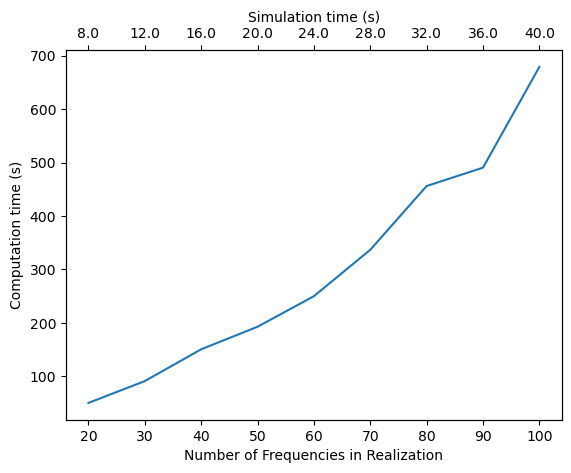

In [128]:
# Plot the computation time vs. number of frequencies

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(nfreqs,runtime)
ax1.set_xlabel('Number of Frequencies in Realization')
ax1.set_ylabel('Computation time (s)')

# also plot total time
tperreal = 1/.02

def tick_function(X):
    V = [(1/(fend/nfreq)) for nfreq in X]
    print(V)
    return ["%.1f" % z for z in V]

ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax1.get_xticks()))
ax2.set_xlabel('Simulation time (s)')

Text(0, 0.5, 'Total computation time needed (20 min)')

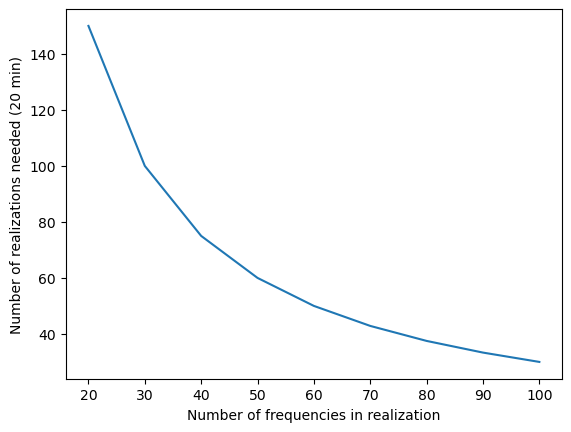

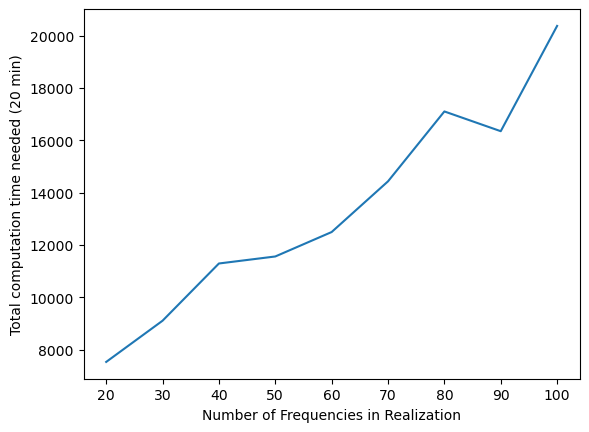

In [129]:
# plot total simulation time for each number of frequencies

minutes_needed = 20
sim_times = [(1/(fend/nfreq)) for nfreq in nfreqs]

nrealizations_needed = [minutes_needed*60/sim_time for sim_time in sim_times]

#print(nrealizations_needed.type())
total_times = [a*b for a, b in zip(nrealizations_needed,runtime)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(nfreqs,nrealizations_needed)
ax1.set_xlabel('Number of frequencies in realization')
ax1.set_ylabel('Number of realizations needed (20 min)')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(nfreqs,total_times)
ax1.set_xlabel('Number of Frequencies in Realization')
ax1.set_ylabel('Total computation time needed (20 min)')

In [39]:
# record the max absorbable power for each wave 

Pmaxs = []
nfreqs = np.linspace(20,100,9)
fend = 2.5
nrealizations = 1

Hs = .4
Tp = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

for nfreq in nfreqs:
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(fb, freq)

    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
    )

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)
    
    print(f'nfreq: {nfreq}')
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)

    print(f'Max Theoretical Power: {P_ub}')

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 20.0
Max Theoretical Power: -5628.140695694517


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel 

nfreq: 30.0
Max Theoretical Power: -13876.616666190723
('Heave', 'Heave')


nfreq: 40.0
Max Theoretical Power: -11250.792923914052


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.


('Heave', 'Heave')


nfreq: 50.0
Max Theoretical Power: -11835.949280178249


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.34e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 60.0
Max Theoretical Power: -11758.238126044165


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.36e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 70.0
Max Theoretical Power: -11748.564060848348


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.66e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.36e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.17e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.92e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.56e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 80.0
Max Theoretical Power: -11760.745925925821


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.41e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.41e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.24e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 90.0
Max Theoretical Power: -11755.283142009781


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.72e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.


('Heave', 'Heave')


nfreq: 100.0
Max Theoretical Power: -11756.76792011349


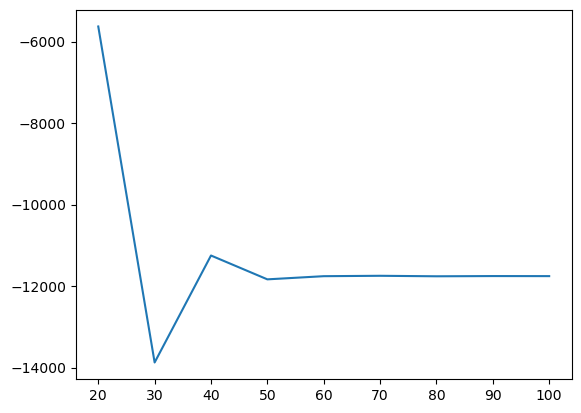

In [40]:
plt.figure()
plt.plot(nfreqs, Pmaxs)